In [1]:
import b3d
import jax.numpy as jnp
import os
from b3d import Mesh, Pose
import jax
import genjax
from genjax import Pytree
import rerun as rr
from b3d.modeling_utils import uniform_discrete, uniform_pose, gaussian_vmf
import matplotlib.pyplot as plt
from functools import partial
import importlib
from ipywidgets import interact
import ipywidgets as widgets
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from genjax import SelectionBuilder as S


In [2]:
b3d.rr_init("slam")
key = jax.random.PRNGKey(0)

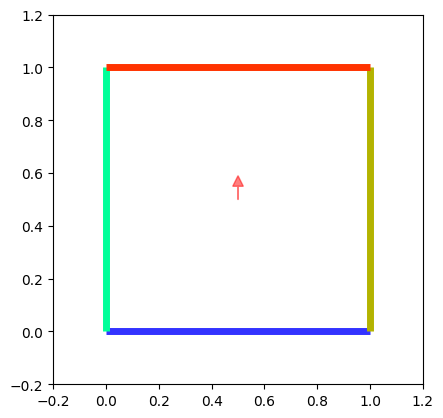

In [3]:
room_h, room_w = 1.0, 1.0
line_segments = jnp.array(
    [
        [0.0, 0.0, room_w, 0.0, 51/255., 51/255.0, 1.0],
        [0.0, 0.0, 0, room_h, 0.0, 1.0, 153.0/255],
        [room_w, 0.0, room_w, room_h, 179/255., 179/255., 0.0],
        [0.0, room_h, room_w, room_h, 1.0, 51.0/255., 0.0,],
    ]
)



def line_segment_to_mesh(line_segment):
    a, b, c, d, r1, g1, b1 = line_segment
    vertices = jnp.array(
        [
            [a, world_height / 2, b],
            [a, -world_height / 2, b],
            [c, -world_height / 2, d],
            [c, world_height / 2, d],
        ]
    )
    faces = jnp.array(
        [
            [0, 1, 3],
            [3, 1, 2],
        ]
    )
    vertex_attributes = jnp.ones((len(vertices), 3)) * jnp.array([r1, g1, b1])
    return Mesh(vertices, faces, vertex_attributes)


epsilon = 0.03
num_rooms = 1
line_segments = jnp.concatenate([
    line_segments + jnp.array([(room_w + epsilon) * (i), 0.0, (room_w + epsilon) * (i), 0.0, 0.0, 0.0, 0.0])
    for i in range(num_rooms)
])
world_height = 0.5
world_mesh = Mesh.squeeze_mesh(jax.vmap(line_segment_to_mesh)(line_segments))
world_mesh.rr_visualize("mesh")

def draw_world(ax):
    from matplotlib.collections import LineCollection

    import matplotlib.pyplot as plt

    # Convert line_segments to a list of line coordinates
    lines = [((seg[0], seg[1]), (seg[2], seg[3])) for seg in line_segments]
    c = [(*l[4:], 1.0) for l in line_segments]

    # Create a LineCollection with the lines and colors
    lc = LineCollection(lines, colors=c, linewidth=5)
    # Add the LineCollection to the axes
    ax.add_collection(lc)

    # Set the limits of the axes
    ax.set_xlim(-0.2, 1.2)
    ax.set_ylim(-0.2, 1.2)

    ax.set_aspect("equal")
    # Show the figure

def draw_pose(ax, pose, color=(0.0, 0.0, 0.0, 1.0)):
    r = 0.05
    x,_,z = pose.pos
    R = pose.as_matrix()[:3,:3][:,2]
    ax.arrow(x,z, float(R[0]) * r, float(R[2]) * r, head_width=0.04, head_length=0.04, fc=color, ec=color, alpha=0.5)

fig, ax = plt.subplots()
draw_world(ax)
draw_pose(ax, Pose.from_pos(jnp.array([0.5, 0.0, 0.5])), (1.0, 0.0, 0.0, 1.0))
# draw_pose(ax, jnp.array([0.2, 0.4, 0.1]), (0.0, 0.0, 0.0, 1.0))

In [4]:
b3d.reload(b3d.renderer.renderer_original)
renderer = b3d.renderer.renderer_original.RendererOriginal()

In [5]:
# kernel = b3d.chisight.dense.likelihoods.blur_likelihood.log_gaussian_kernel(
#     b3d.chisight.dense.likelihoods.blur_likelihood.filter_size,
#     50.0
# )
# plt.matshow(jnp.exp(kernel) * kernel.size)
# plt.clim(0,2.0)
# plt.colorbar()

In [12]:
import b3d.chisight.dense.dense_model
b3d.reload(b3d.chisight.dense.dense_model)
b3d.reload(b3d.utils)
import b3d.chisight.dense.likelihoods.blur_likelihood_gaussian
import b3d.chisight.dense.likelihoods.blur_likelihood
b3d.reload(b3d.chisight.dense.likelihoods.blur_likelihood_gaussian)
b3d.reload(b3d.chisight.dense.likelihoods.blur_likelihood)
intermediate_likelihood_func = b3d.chisight.dense.likelihoods.blur_likelihood.blur_intermediate_likelihood_func
# intermediate_likelihood_func = b3d.chisight.dense.likelihoods.blur_likelihood_gaussian.blur_intermediate_likelihood_func
model, viz_trace, info_from_trace = (
    b3d.chisight.dense.dense_model.make_dense_multiobject_model(
        renderer, intermediate_likelihood_func
    )
)
importance_jit = jax.jit(model.importance)

grid_point_to_pose = jax.jit(lambda x: Pose(
    jnp.array([x[0], 0.0, x[1]]),
    b3d.Rot.from_rotvec(jnp.array([0.0, x[2], 0.0])).as_quat()
))

In [13]:
IDX = 4
k = 200
keys = jax.random.split(key, 2 * k)
rows = jax.vmap(genjax.categorical.sample,in_axes=(0, 0,))(
        keys[:k],
        jnp.ones((k, renderer.height)))
cols = jax.vmap(genjax.categorical.sample,in_axes=(0, 0,))(
        keys[k:],
        jnp.ones((k, renderer.width)))

likelikood_args = {
    "fx": renderer.fx,
    "fy": renderer.fy,
    "cx": renderer.cx,
    "cy": renderer.cy,
    "rows":  rows,
    "cols": cols,
}

gt_camera_pose = grid_point_to_pose(jnp.array([0.81, 0.21, 0.1]))
rgbd = renderer.render_rgbd_from_mesh(world_mesh.transform(gt_camera_pose.inv()))

latent_camera_pose = grid_point_to_pose(jnp.array([0.75, 0.21, 0.1]))
choicemap = genjax.ChoiceMap.d(
    {
        "rgbd": rgbd,
        "camera_pose": latent_camera_pose,
        "object_pose_0": Pose.identity(),
        "color_variance_0": 0.2,
        "depth_variance_0": 10.0,
        "outlier_probability_0": 0.1,
        "blur": 0.001,
    }
)

key = jax.random.PRNGKey(0)
trace = importance_jit(
    key,
    choicemap,
    (
        {
            "num_objects": Pytree.const(1),
            "meshes": [world_mesh],
            "likelihood_args": likelikood_args,
        },
    ),
)[0]

print(trace.get_score())


viz_trace(trace)
# viz_trace(importance_jit(
#     key,
#     trace.get_choices().filter( ~S["rgbd"]),
#     trace.get_args(),
# )[0])
info = info_from_trace(trace)

1372.8082


In [16]:
color_variance_sweep = jnp.linspace(0.05, 0.4, 5)
depth_variance_sweep = jnp.linspace(0.05, 0.4, 5)
outlier_probability_sweep = jnp.linspace(0.01, 0.4, 10)
blur_sweep = jnp.linspace(0.001, 50.0, 30)

addresses= Pytree.const(("color_variance_0", "depth_variance_0", "outlier_probability_0","blur"))
sweeps = [color_variance_sweep, depth_variance_sweep, outlier_probability_sweep, blur_sweep]
scores = b3d.utils.grid_trace(
    trace,
    addresses,
    sweeps,
)

In [15]:
color_variance_sweep = jnp.linspace(0.05, 0.4, 5)
depth_variance_sweep = jnp.linspace(0.05, 0.4, 5)
outlier_probability_sweep = jnp.linspace(0.01, 0.4, 10)
blur_sweep = jnp.linspace(0.001, 50.0, 30)

addresses= Pytree.const(("color_variance_0", "depth_variance_0", "outlier_probability_0","blur"))
sweeps = [color_variance_sweep, depth_variance_sweep, outlier_probability_sweep, blur_sweep]
scores = b3d.utils.grid_trace(
    trace,
    addresses,
    sweeps,
)
scores

Array([[[[ 658.36786,  652.8536 ,  650.1209 , ...,  648.8266 ,
           648.82605,  648.82556],
         [ 773.1672 ,  767.653  ,  764.9204 , ...,  763.62604,
           763.62555,  763.62506],
         [ 809.9908 ,  804.47675,  801.7442 , ...,  800.4499 ,
           800.4493 ,  800.44885],
         ...,
         [ 859.5745 ,  854.06134,  851.32916, ...,  850.03503,
           850.0345 ,  850.03406],
         [ 860.56146,  855.0484 ,  852.31635, ...,  851.02234,
           851.02185,  851.0213 ],
         [ 859.8962 ,  854.3835 ,  851.65155, ...,  850.35754,
           850.357  ,  850.35657]],

        [[1162.1727 , 1468.4181 , 1485.7543 , ..., 1489.4052 ,
          1489.4064 , 1489.4075 ],
         [1208.2234 , 1461.2231 , 1478.5297 , ..., 1482.1787 ,
          1482.1799 , 1482.181  ],
         [1219.3851 , 1452.5349 , 1469.809  , ..., 1473.4562 ,
          1473.4573 , 1473.4584 ],
         ...,
         [1210.964  , 1399.4147 , 1416.4718 , ..., 1420.1056 ,
          1420.1068 , 142

In [78]:
key = b3d.split_key(key)


latent_camera_pose = grid_point_to_pose(jnp.array([0.76, 0.21, 0.1]))
trace = b3d.update_choices(trace, Pytree.const(("camera_pose",)), latent_camera_pose)
viz_trace(trace)

color_variance_sweep = jnp.linspace(0.05, 0.4, 5)
depth_variance_sweep = jnp.linspace(0.05, 0.4, 5)
outlier_probability_sweep = jnp.linspace(0.01, 0.4, 10)
blur_sweep = jnp.linspace(0.001, 50.0, 30)

addresses= Pytree.const(("color_variance_0", "depth_variance_0", "outlier_probability_0","blur"))
sweeps = [color_variance_sweep, depth_variance_sweep, outlier_probability_sweep, blur_sweep]
scores = b3d.utils.grid_trace(
    trace,
    addresses,
    sweeps,
)
index = jnp.unravel_index(scores.argmax(), scores.shape)

sampled_indices = jax.vmap(jnp.unravel_index, in_axes=(0, None))(
    jax.random.categorical(key, scores.reshape(-1), shape=(1000,)), scores.shape
)
sampled_parameters = jnp.vstack(
    [sweep[indices] for indices, sweep in zip(sampled_indices, sweeps)]
).T
print(sampled_parameters[:10])

[[1.3750000e-01 3.1250000e-01 9.9999998e-03 3.9655376e+01]
 [3.1250000e-01 4.0000001e-01 9.9999998e-03 1.0345621e+01]
 [3.1250000e-01 2.2500001e-01 9.9999998e-03 2.5862551e+01]
 [2.2500001e-01 3.1250000e-01 9.9999998e-03 3.6207172e+01]
 [4.0000001e-01 3.1250000e-01 9.9999998e-03 2.4138447e+01]
 [3.1250000e-01 3.1250000e-01 9.9999998e-03 2.7586655e+01]
 [1.3750000e-01 3.1250000e-01 9.9999998e-03 1.7242033e+01]
 [2.2500001e-01 4.0000001e-01 9.9999998e-03 3.6207172e+01]
 [5.0000001e-02 4.0000001e-01 9.9999998e-03 3.4483067e+01]
 [1.3750000e-01 3.1250000e-01 9.9999998e-03 3.4492068e+00]]


In [79]:
t = b3d.update_choices(trace, Pytree.const(("outlier_probability_0",)), 0.0001)
viz_trace(t)
print(t.get_score())

1463.9447


# Part 1: Posterior on Blur given different latent hypotheses

In [82]:
traces_and_samples = []
blur_extended_sweep = jnp.linspace(0.01, 50.0, 200)
for x_coorindate in tqdm(jnp.linspace(0.50, 1.0, 200)):
    latent_camera_pose = grid_point_to_pose(jnp.array([x_coorindate, 0.21, 0.1]))
    trace = b3d.update_choices(trace, Pytree.const(("camera_pose",)), latent_camera_pose)

    addresses= Pytree.const(("color_variance_0", "depth_variance_0", "outlier_probability_0","blur"))
    sweeps = [color_variance_sweep, depth_variance_sweep, outlier_probability_sweep, blur_sweep]
    scores = b3d.utils.grid_trace(
        trace,
        addresses,
        sweeps,
    )

    index = jnp.unravel_index(scores.argmax(), scores.shape)

    sampled_indices = jax.vmap(jnp.unravel_index, in_axes=(0, None))(
        jax.random.categorical(key, scores.reshape(-1), shape=(1000,)), scores.shape
    )
    sampled_parameters = jnp.vstack(
        [sweep[indices] for indices, sweep in zip(sampled_indices, sweeps)]
    ).T

    traces_and_samples.append((trace, sampled_parameters))


100%|██████████| 200/200 [00:05<00:00, 34.84it/s]


In [88]:
traces_and_samples[0][1]

Array([[ 0.3125    ,  0.4       ,  0.4       , 20.69024   ],
       [ 0.3125    ,  0.4       ,  0.27      , 34.483067  ],
       [ 0.05      ,  0.4       ,  0.27      , 18.966137  ],
       ...,
       [ 0.22500001,  0.4       ,  0.4       , 39.655376  ],
       [ 0.22500001,  0.4       ,  0.31333333, 32.758965  ],
       [ 0.22500001,  0.4       ,  0.31333333, 12.069723  ]],      dtype=float32)

In [90]:
def _make_viz(t, filename=None):
    trace, sampled_parameters = traces_and_samples[t]

    fig, axs = plt.subplots(1, 5, figsize=(20, 5))

    axs[0].imshow(trace.get_choices()["rgbd"][...,:3])
    axs[0].set_title('Observed Image', fontsize=20)
    axs[0].axis('off')

    draw_world(axs[1])
    draw_pose(axs[1], gt_camera_pose)
    draw_pose(axs[1], trace.get_choices()["camera_pose"],(1.0, 0.0, 0.0, 1.0))
    axs[1].axis('off')
    axs[1].set_title('Latent Hypothesis - Pose', fontsize=20)

    axs[2].imshow(trace.get_retval()["latent_rgbd"][...,:3])
    axs[2].set_title('Latent Hypothesis - Image', fontsize=20)
    axs[2].axis('off')
    
    # Plot histogram for the third subplot
    axs[3].hist(sampled_parameters[:,3], blur_sweep)
    axs[3].set_title('Posterior on Blur', fontsize=20)
    axs[3].set_xlim(blur_sweep.min(), blur_sweep.max())

    
    # Plot histogram for the third subplot
    axs[4].hist(sampled_parameters[:,2], outlier_probability_sweep)
    axs[4].set_title('Posterior on Outlier Prob', fontsize=20)
    axs[4].set_xlim(outlier_probability_sweep.min(), outlier_probability_sweep.max())

    # Adjust spacing between subplots
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
        return
    plt.show()

interact(_make_viz,
    t = widgets.IntSlider(value=1, min=0, max=len(traces_and_blur_samples)-1, step=1, continuous_update=False),
    filename = widgets.fixed(None)
)

interactive(children=(IntSlider(value=1, continuous_update=False, description='t', max=199), Output()), _dom_c…

<function __main__._make_viz(t, filename=None)>

KeyboardInterrupt: 

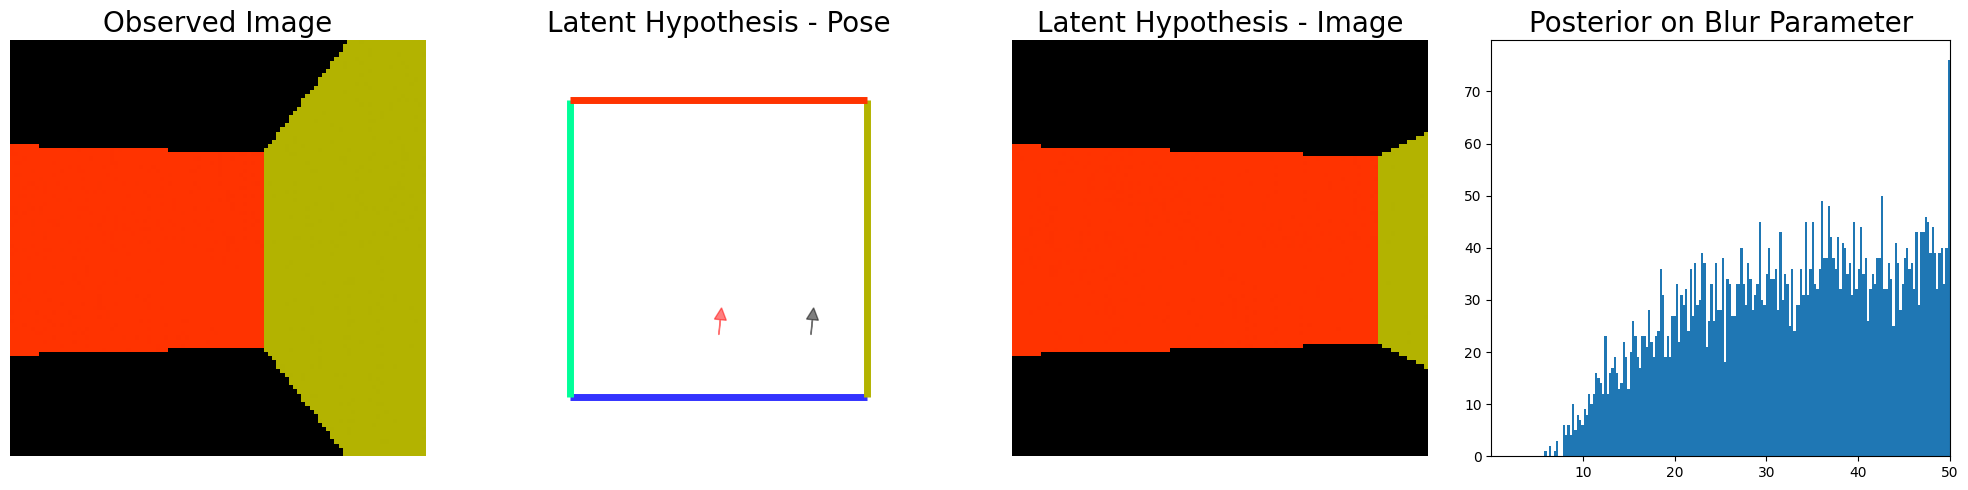

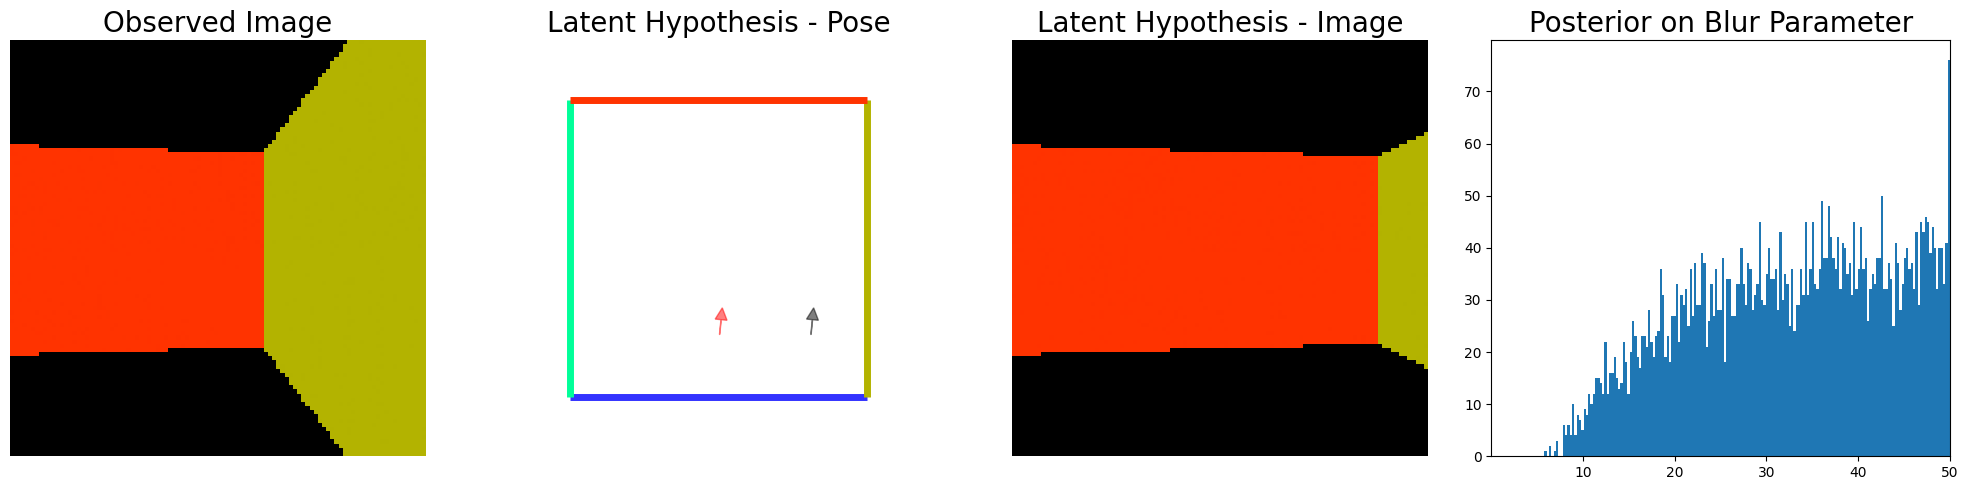

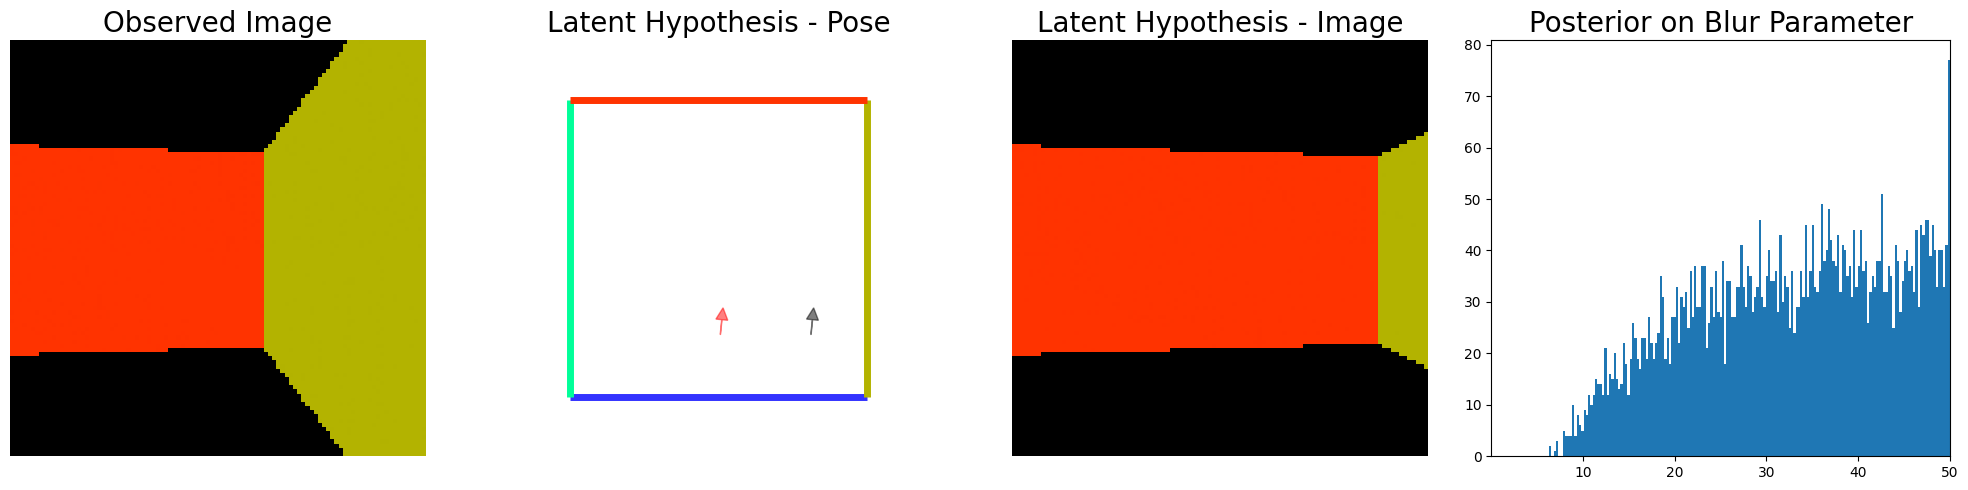

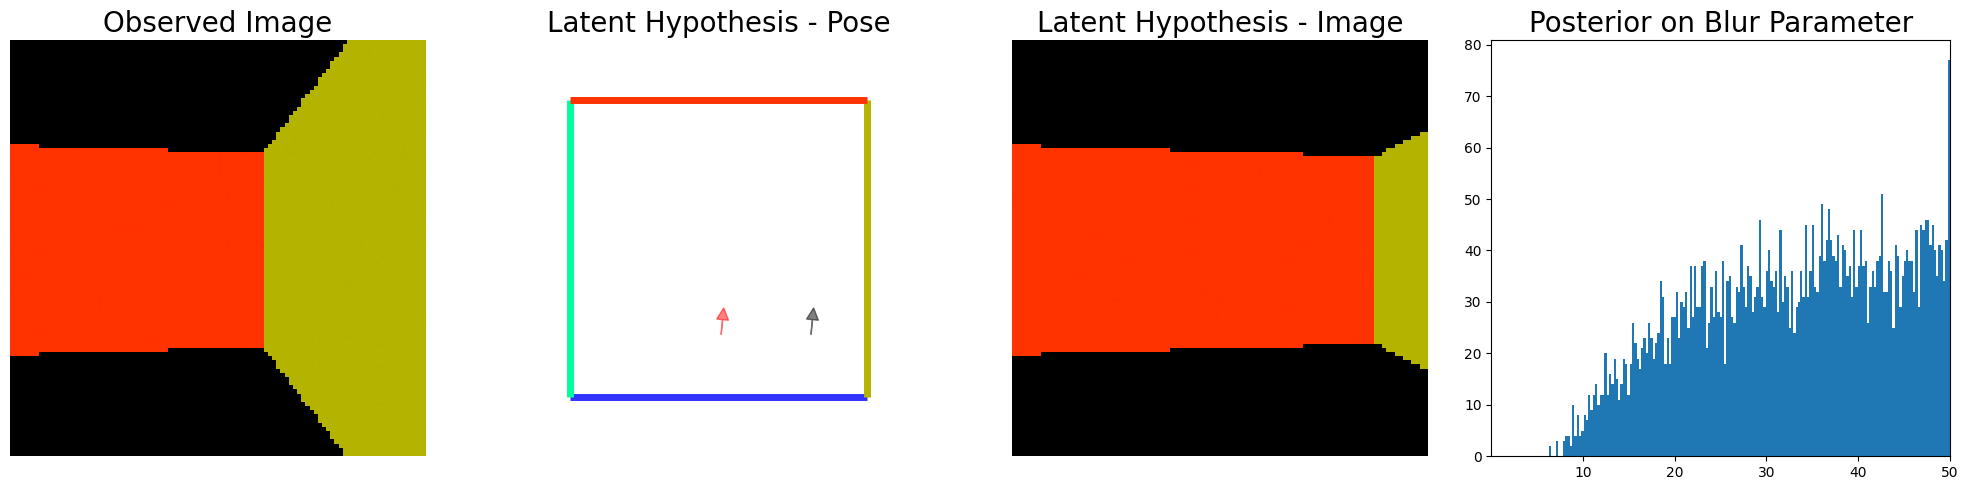

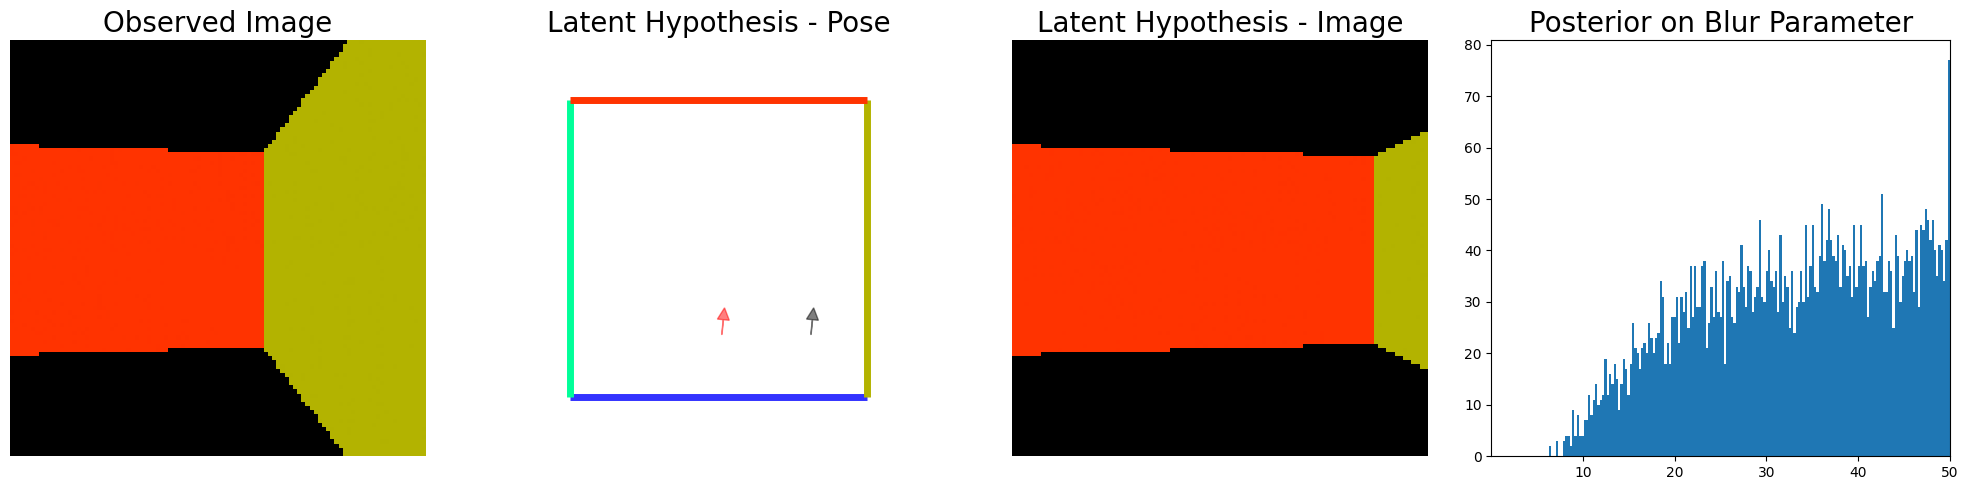

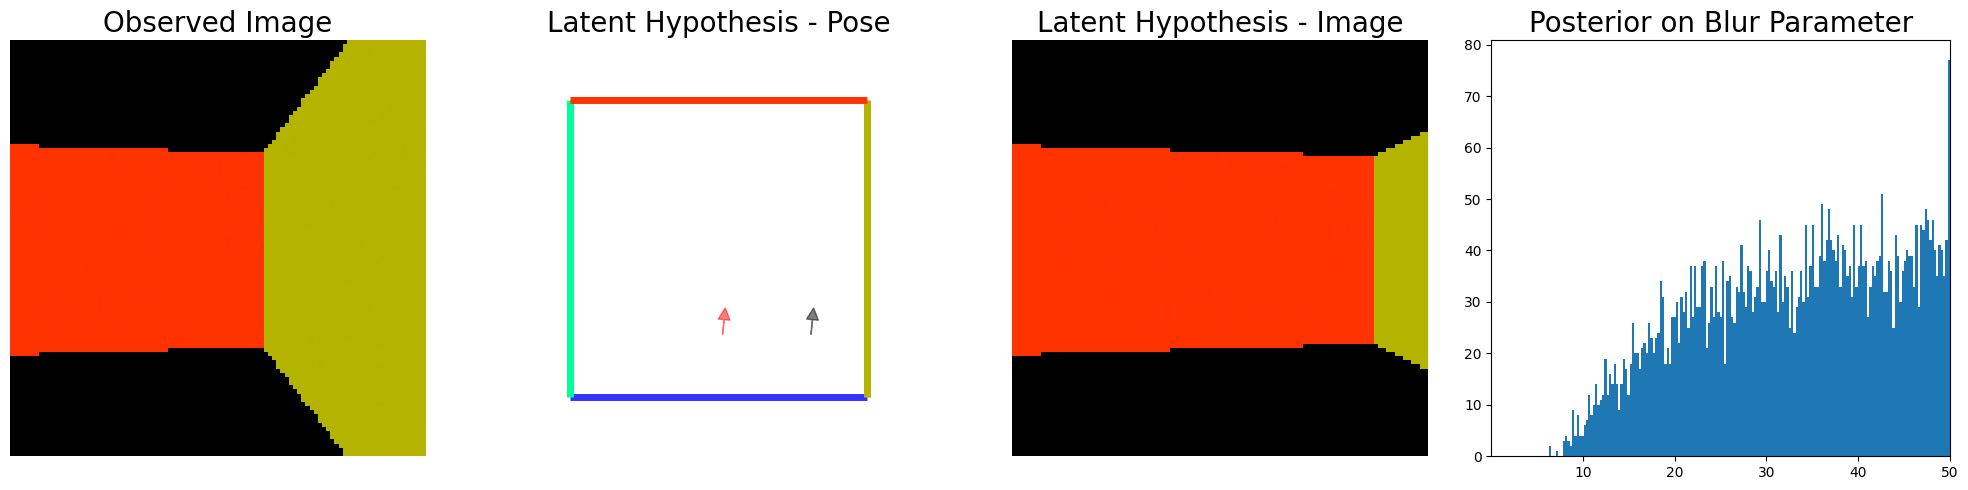

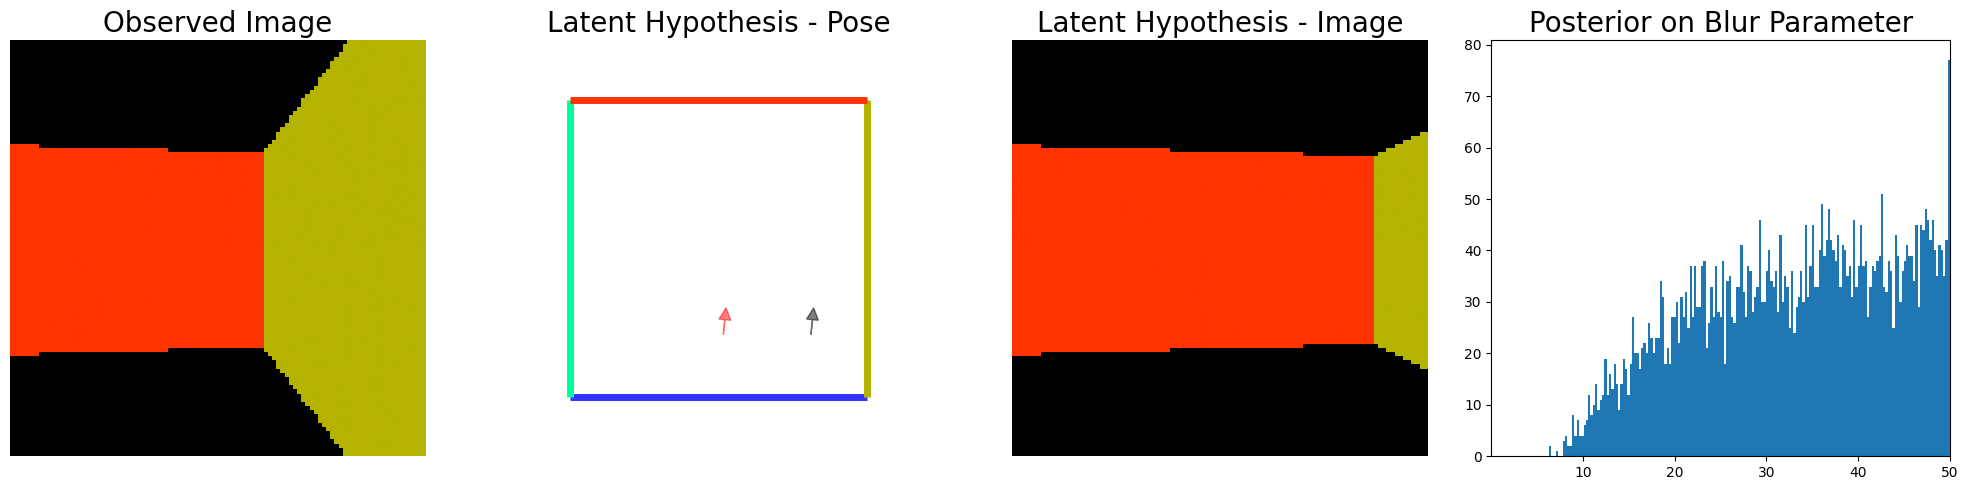

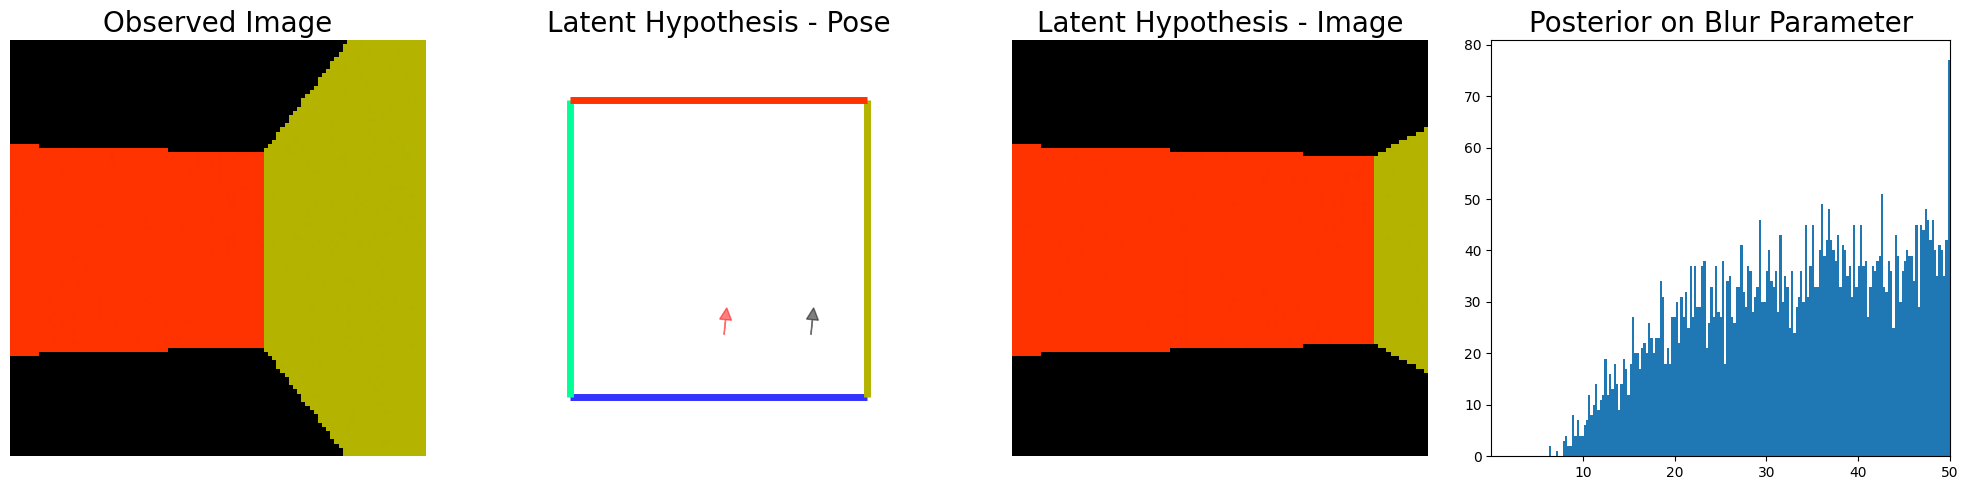

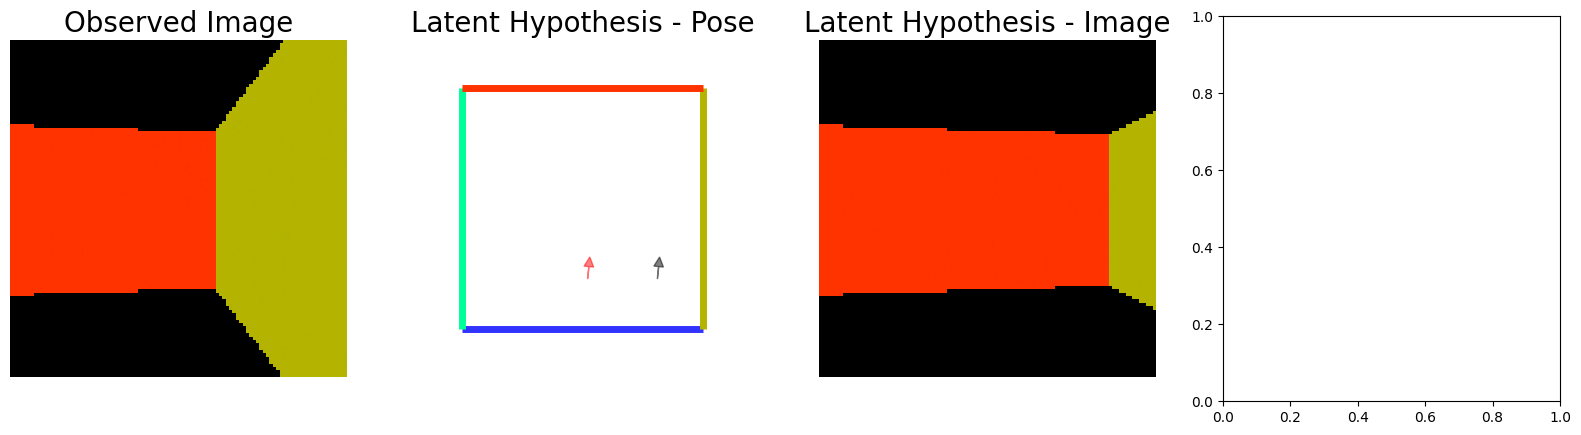

In [21]:
import tempfile
import subprocess

# Generate a random tmp directory name
tmp_dir = tempfile.mkdtemp()
output_filename = "part1.mp4"
fps = 10
# Write files into the tmp directory
for t in range(len(traces_and_blur_samples)):
    _make_viz(t,os.path.join(tmp_dir, "%07d.png" % t));

subprocess.call(
    [
        "ffmpeg",
        "-hide_banner",
        "-loglevel",
        "error",
        "-y",
        "-r",
        str(fps),
        "-i",
        os.path.join(tmp_dir, "%07d.png"),
        output_filename,
    ]
)


# Part 2: Evolution of Inference

In [23]:
w = 0.2
wz = 0.2
low, high, num = (
    jnp.array([-w, -wz, -jnp.pi / 4]),
    jnp.array([w, wz, jnp.pi / 4]),
    jnp.array([15, 15, 7]),
)
base_grid_points = b3d.utils.make_grid_points(low, high, num)

grid_points_to_poses = jax.jit(jax.vmap(grid_point_to_pose))

latent_camera_pose = grid_point_to_pose(jnp.array([0.6, 0.21, -1.5]))
trace = b3d.update_choices(trace, Pytree.const(("camera_pose",)), latent_camera_pose)



color_variance_sweep = jnp.linspace(0.05, 0.4, 5)
outlier_probability_sweep = jnp.linspace(0.01, 0.4, 10)
blur_sweep = jnp.linspace(0.001, 50.0, 30)

viz_trace(trace, 0)

inference_step = 1
traces = []
for i in tqdm(range(5)):
    key = b3d.split_key(key)
    addresses= Pytree.const(("color_variance_0","outlier_probability_0","blur"))
    sweeps = [color_variance_sweep, outlier_probability_sweep, blur_sweep]
    scores = b3d.utils.grid_trace(
        trace,
        addresses,
        sweeps,
    )
    index = jnp.unravel_index(scores.argmax(), scores.shape)

    sampled_indices = jax.vmap(jnp.unravel_index, in_axes=(0, None))(
        jax.random.categorical(key, scores.reshape(-1), shape=(1000,)), scores.shape
    )
    sampled_parameters = jnp.vstack(
        [sweep[indices] for indices, sweep in zip(sampled_indices, sweeps)]
    ).T
    trace = b3d.update_choices(trace, addresses, *sampled_parameters[0])
    traces.append(trace)

    key = b3d.split_key(key)
    grid_noise  = (jax.random.uniform(key, base_grid_points.shape) - 0.5) * (high - low) /num
    pose_grid = grid_points_to_poses(base_grid_points + grid_noise)
    poses = trace.get_choices()["camera_pose"] @ pose_grid

    scores = b3d.enumerate_choices_get_scores(
        trace,
        Pytree.const(("camera_pose",)), poses,
    )


    sampled_indices = jax.random.categorical(key, scores , shape=(5000,))

    trace = b3d.update_choices(trace, Pytree.const(("camera_pose",)), poses[sampled_indices[0]])
    traces.append(trace)
    inference_step += 1
    viz_trace(trace, inference_step)
    # viz_trace(importance_jit(
    #     key,
    #     trace.get_choices().filter( ~S["rgbd"]),
    #     trace.get_args(),
    # )[0])

100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


In [24]:
def _make_viz(t, filename=None):
    trace = traces[t]

    fig, axs = plt.subplots(2, 3, figsize=(20, 10))

    axs[0,0].imshow(trace.get_choices()["rgbd"][...,:3])
    axs[0,0].set_title('Observed Image', fontsize=20)
    axs[0,0].axis('off')

    draw_world(axs[0,1])
    draw_pose(axs[0,1], gt_camera_pose)
    draw_pose(axs[0,1], trace.get_choices()["camera_pose"],(1.0, 0.0, 0.0, 1.0))
    axs[0,1].axis('off')
    axs[0,1].set_title('Latent Hypothesis - Pose', fontsize=20)

    # axs[2].imshow(trace.get_retval()["latent_rgbd"][...,:3])
    # axs[2].set_title('Latent Hypothesis - Noiseless', fontsize=20)
    # axs[2].axis('off')

    image_sample = (importance_jit(
        key,
        trace.get_choices().filter( ~S["rgbd"]),
        trace.get_args(),
    )[0]).get_choices()["rgbd"]

    # Plot histogram for the third subplot
    axs[0,2].imshow(image_sample[...,:3])
    axs[0,2].set_title('Image Sample', fontsize=20)
    axs[0,2].axis('off')

    log_scores = [t.get_score() for t in traces]
    blurs = [t.get_choices()["blur"] for t in traces]
    outlier_prob = [t.get_choices()["outlier_probability_0"] for t in traces]

    axs[1,0].plot(log_scores, linewidth=4)
    axs[1,0].scatter([t], [log_scores[t]], color='red', s=100)
    axs[1,0].set_title('Log Score', fontsize=20)

    axs[1,1].plot(blurs, linewidth=4)
    axs[1,1].scatter([t], [blurs[t]], color='red', s=100)
    axs[1,1].set_title('Blur', fontsize=20)

    axs[1,2].plot(outlier_prob, linewidth=4)
    axs[1,2].scatter([t], [outlier_prob[t]], color='red', s=100)
    axs[1,2].set_title('Outlier Probability', fontsize=20)


    # Adjust spacing between subplots
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
        return
    plt.show()

interact(_make_viz,
    t = widgets.IntSlider(value=1, min=0, max=len(traces)-1, step=1, continuous_update=False),
    filename = widgets.fixed(None)
)

interactive(children=(IntSlider(value=1, continuous_update=False, description='t', max=9), Output()), _dom_cla…

<function __main__._make_viz(t, filename=None)>

0

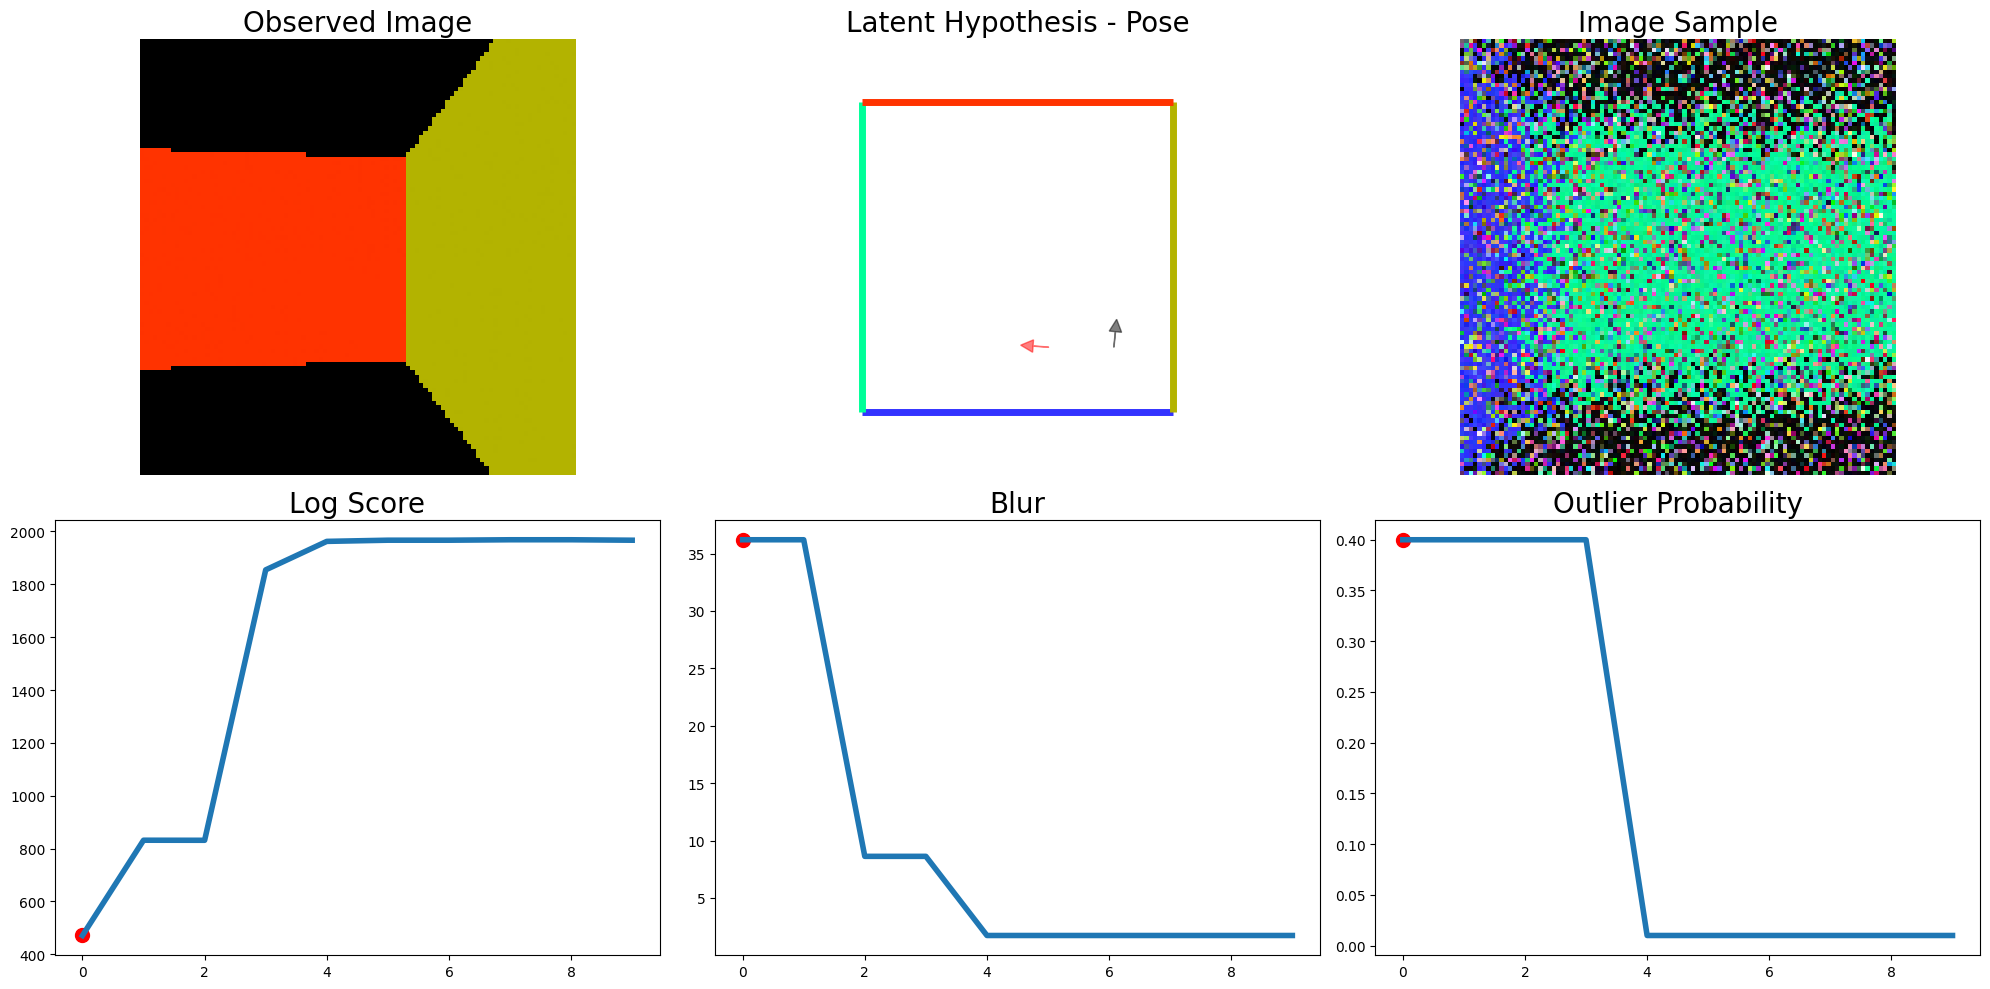

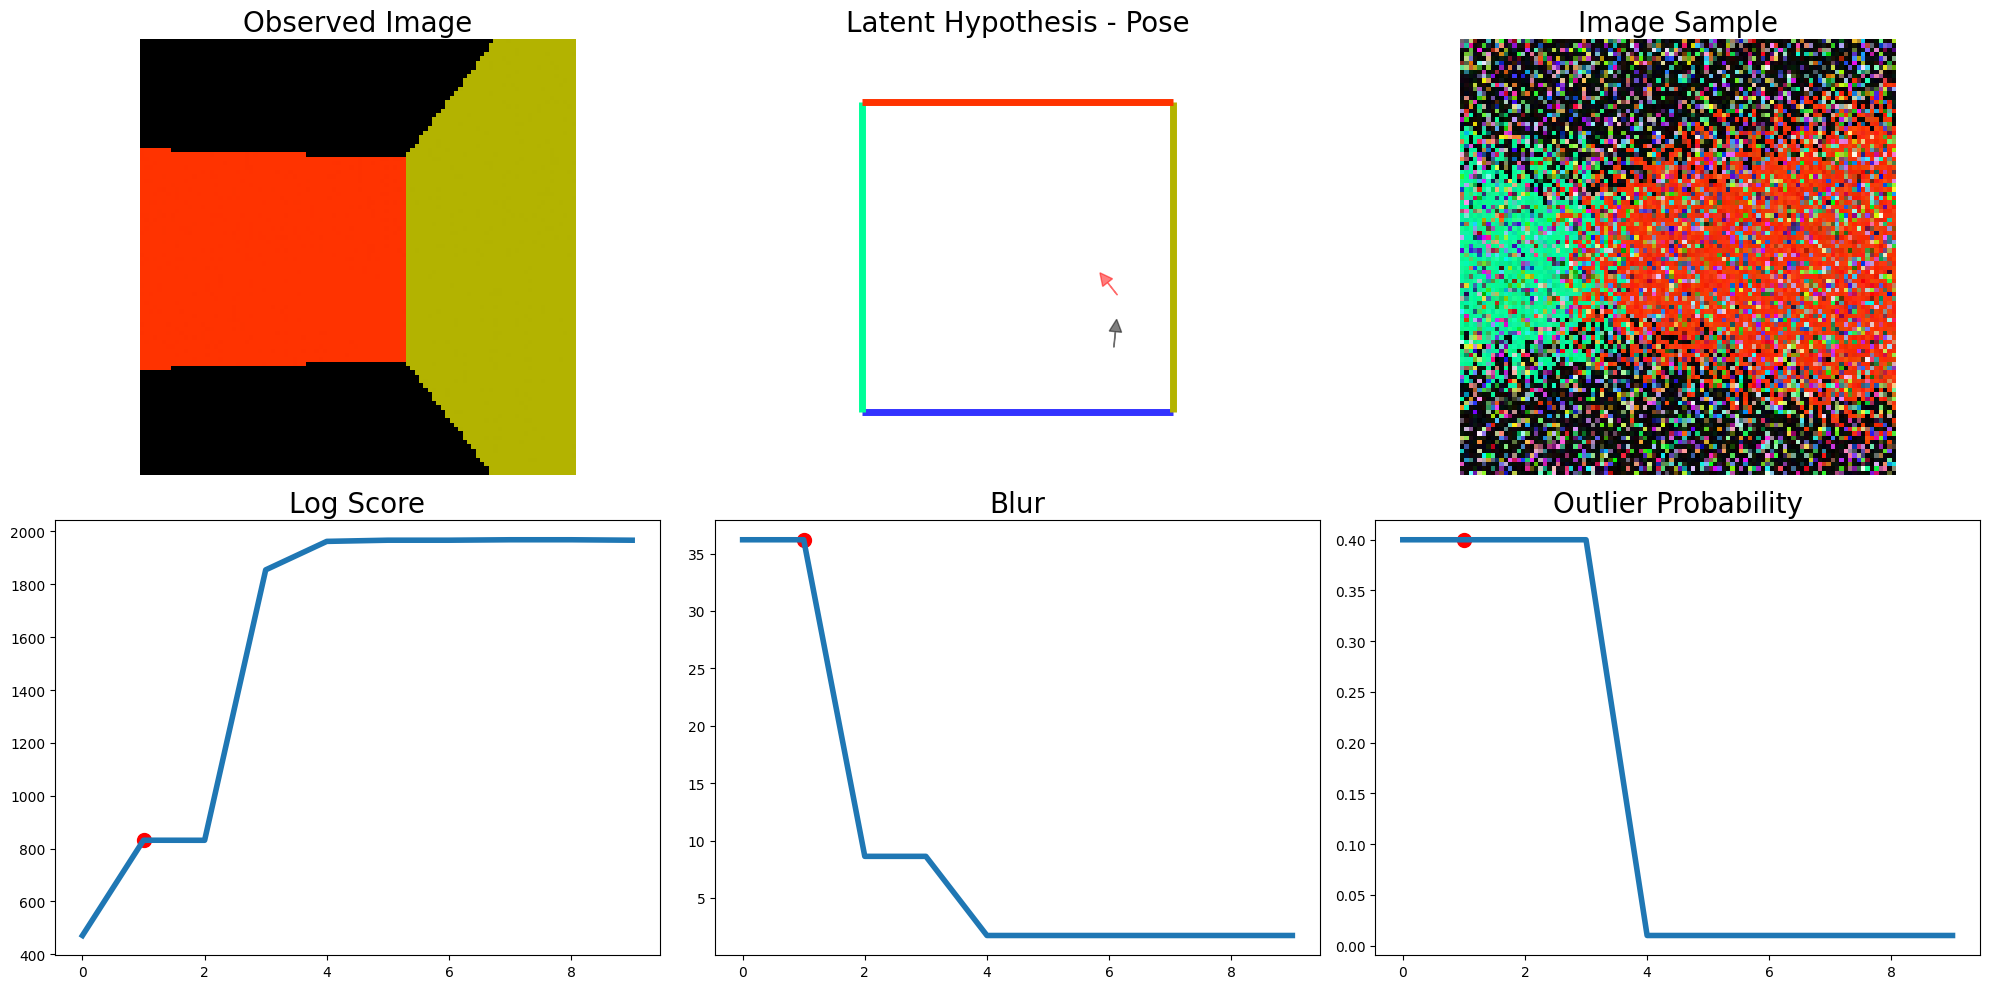

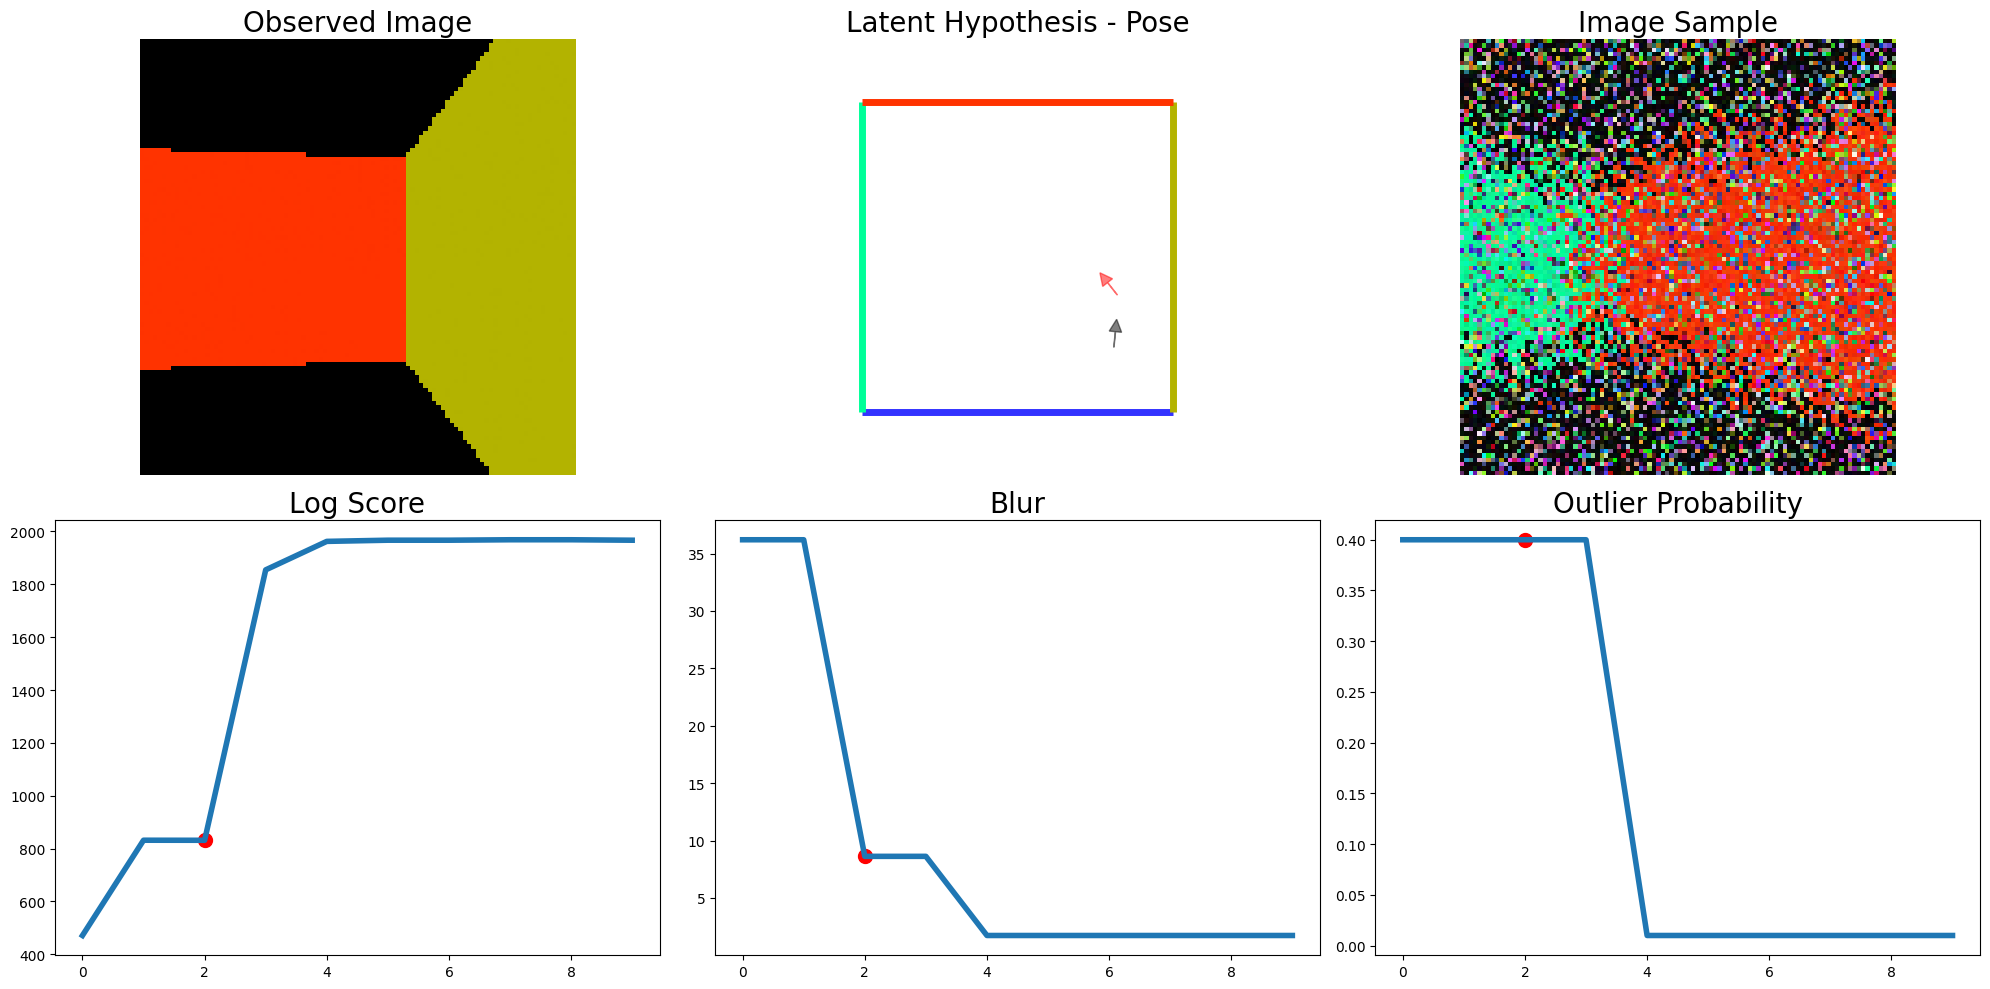

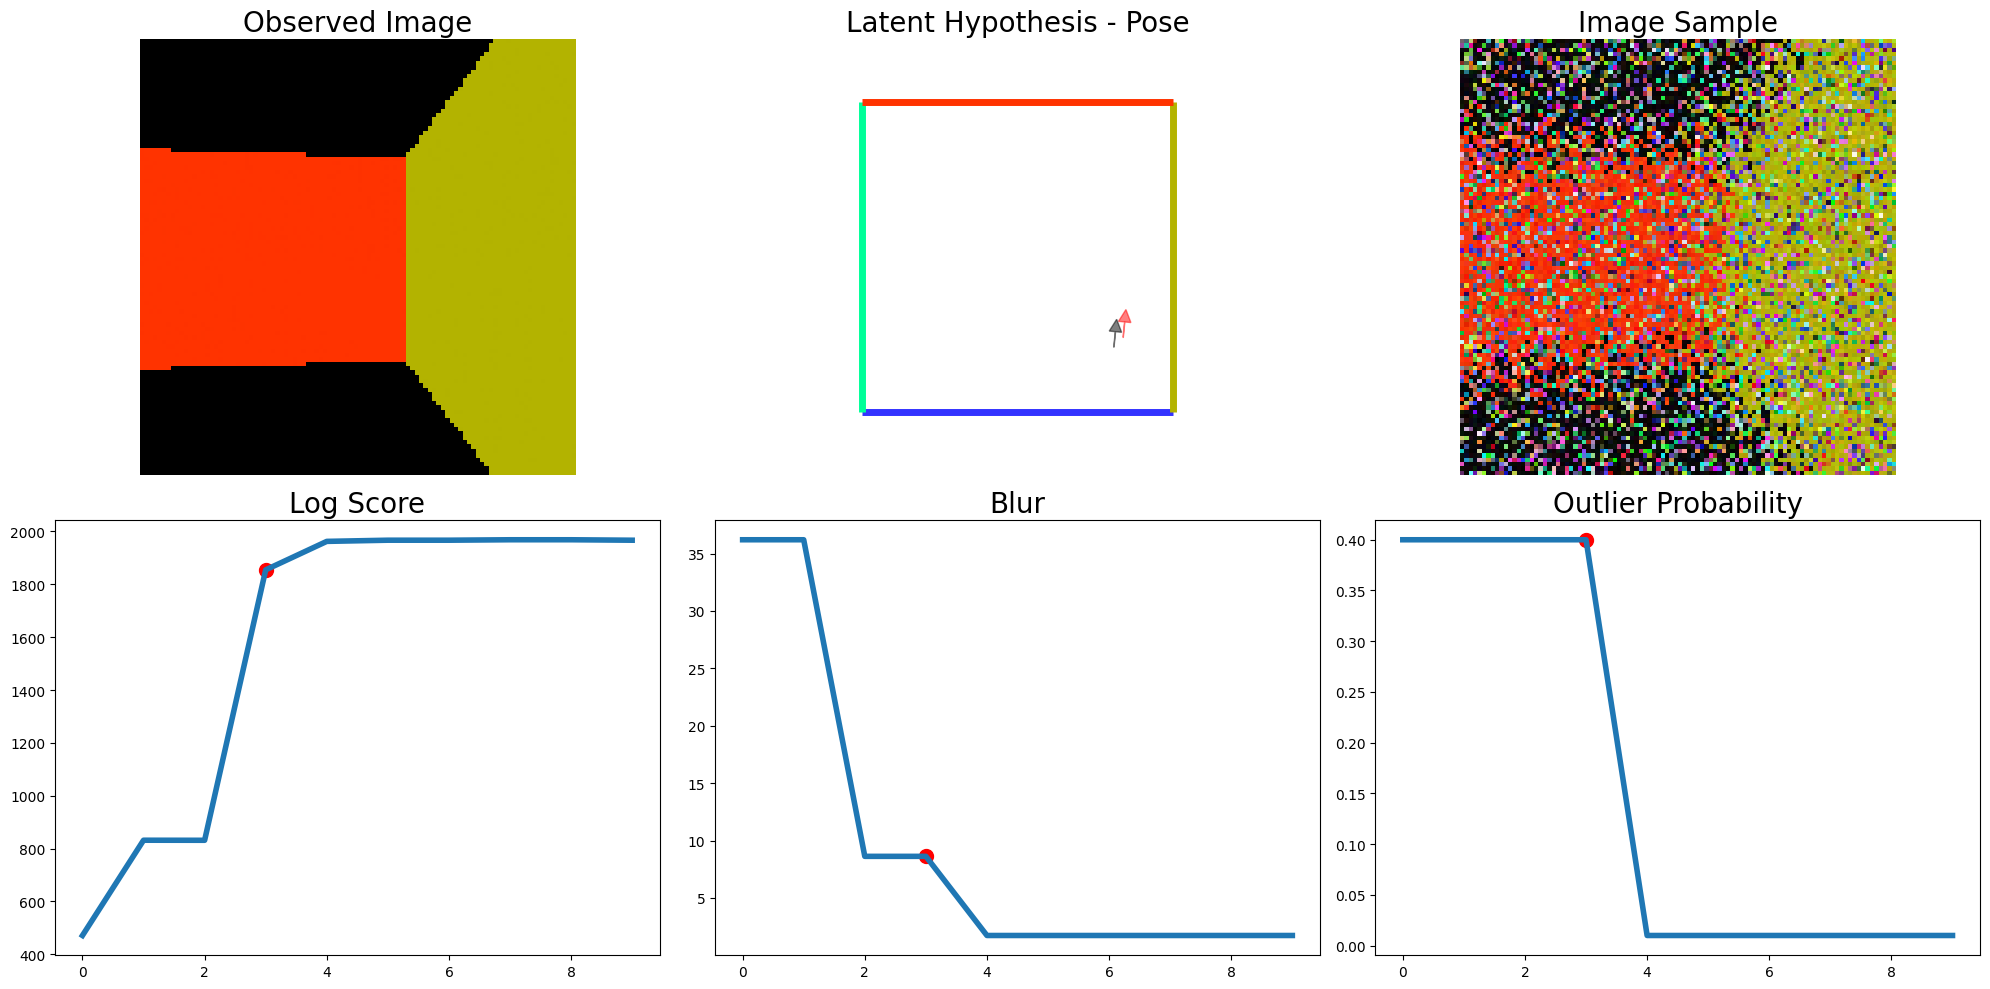

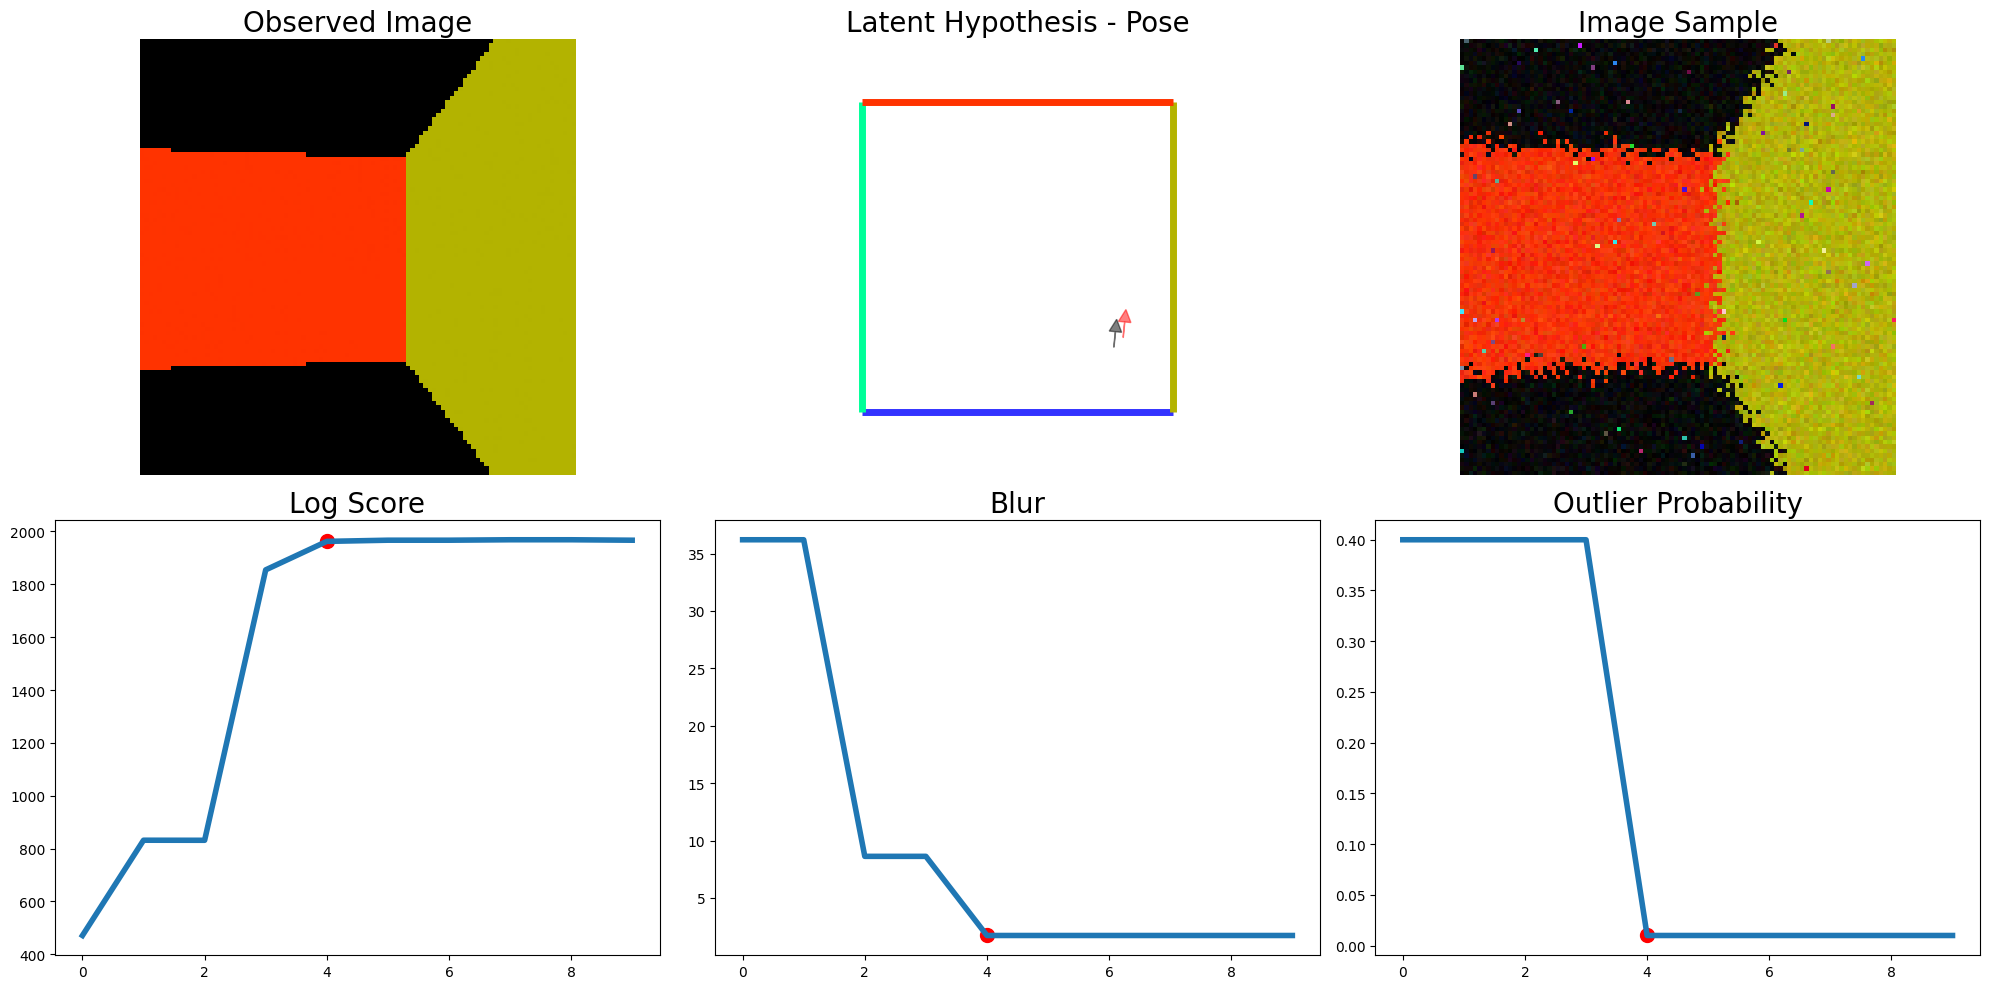

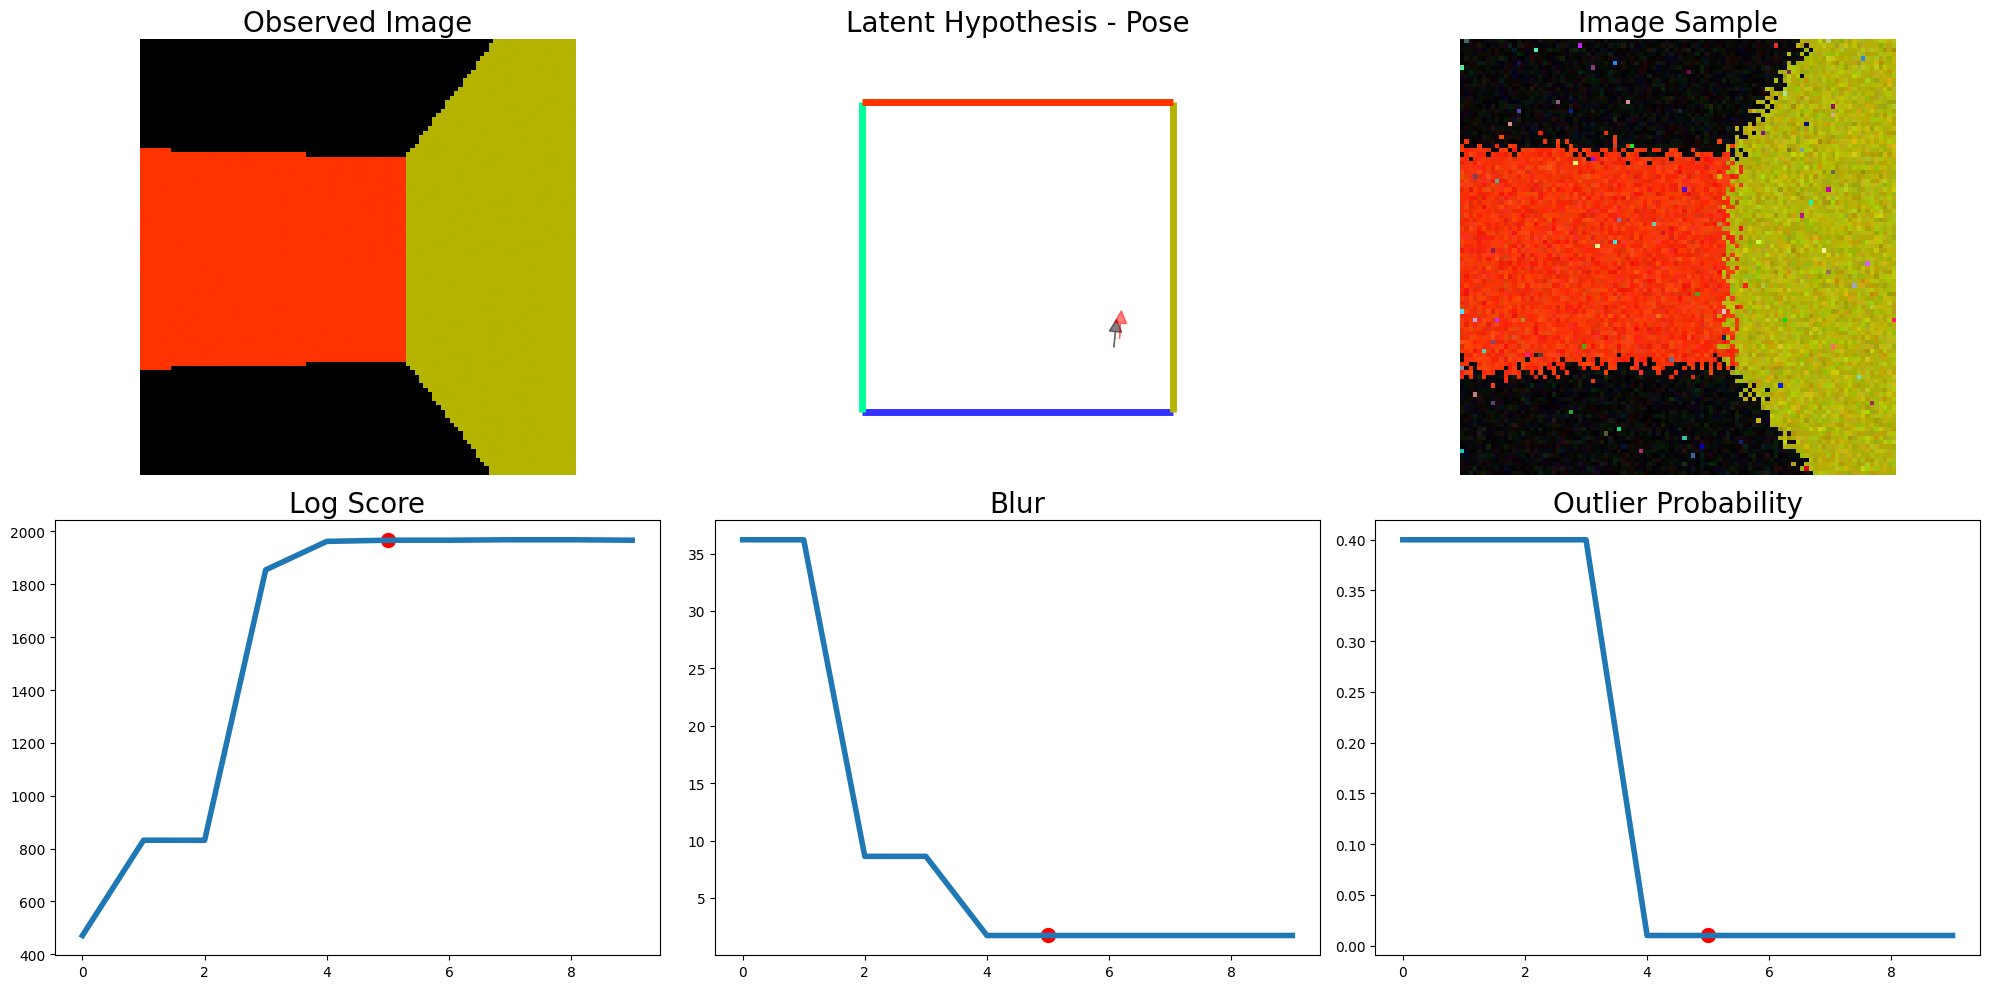

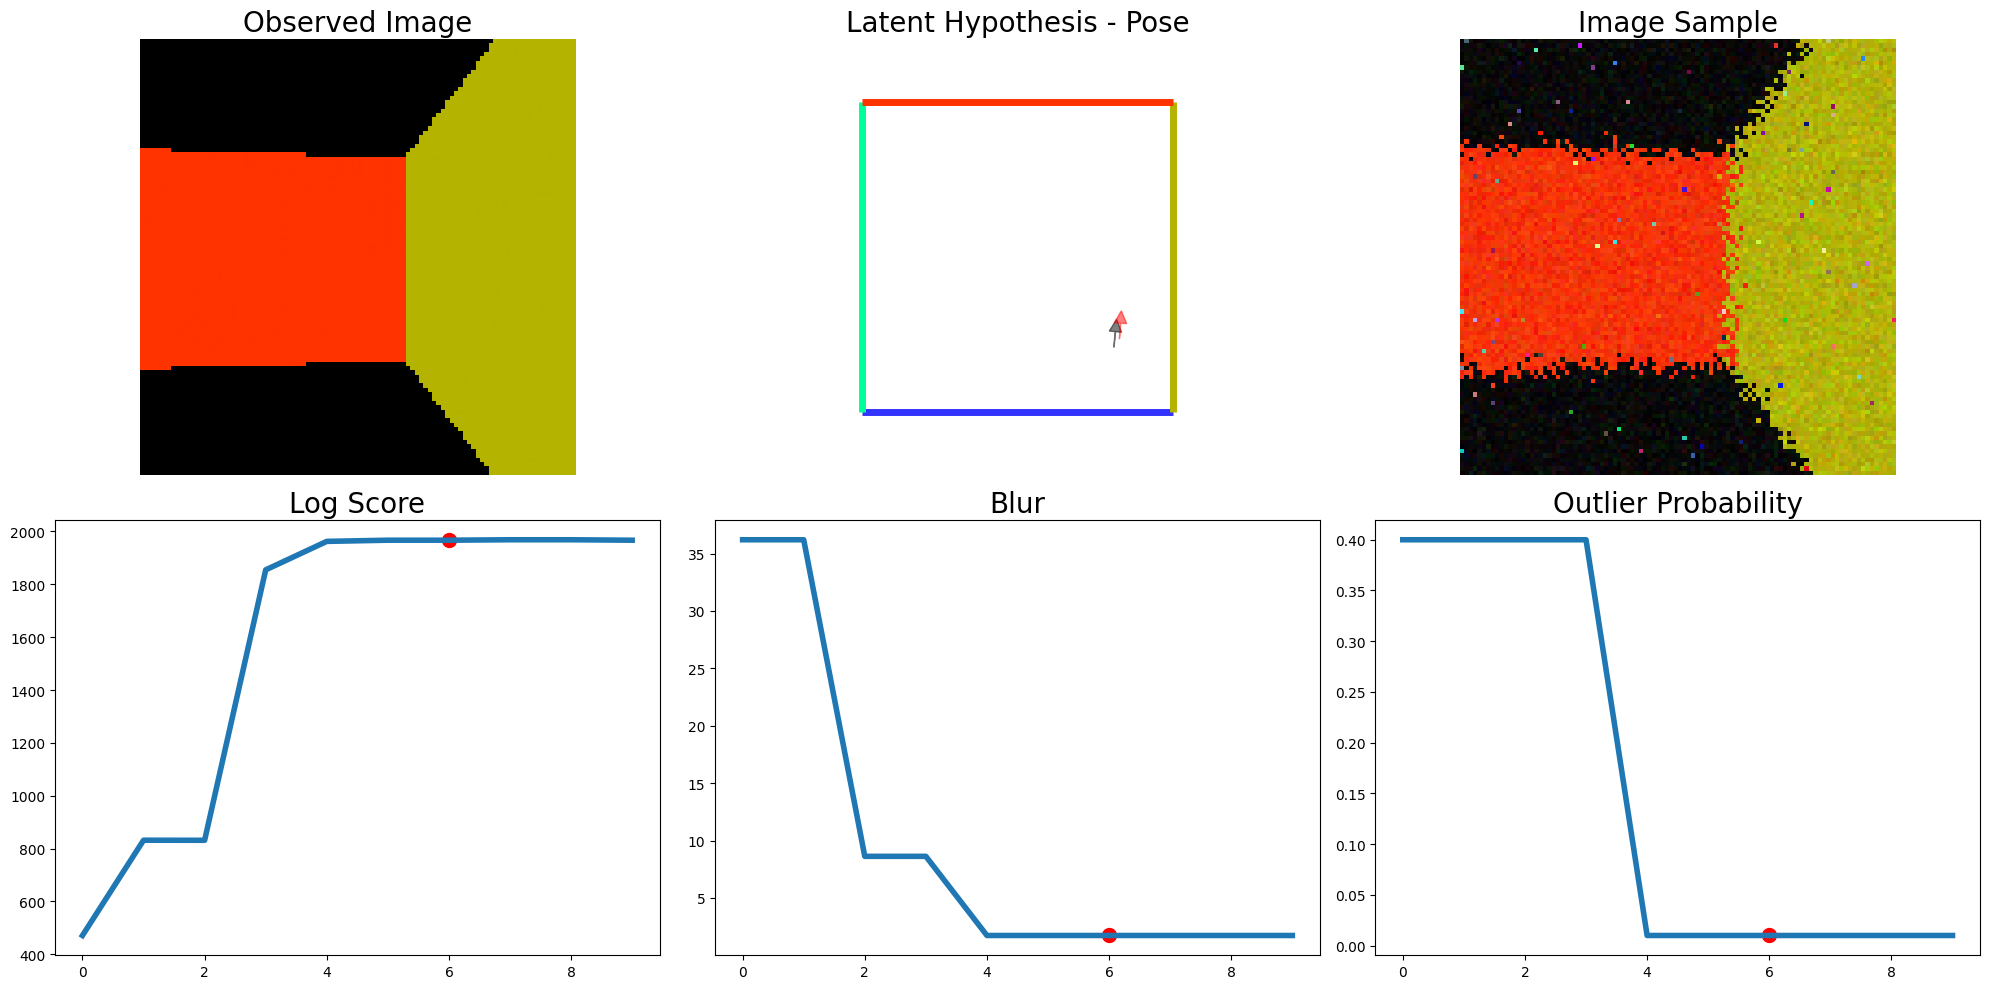

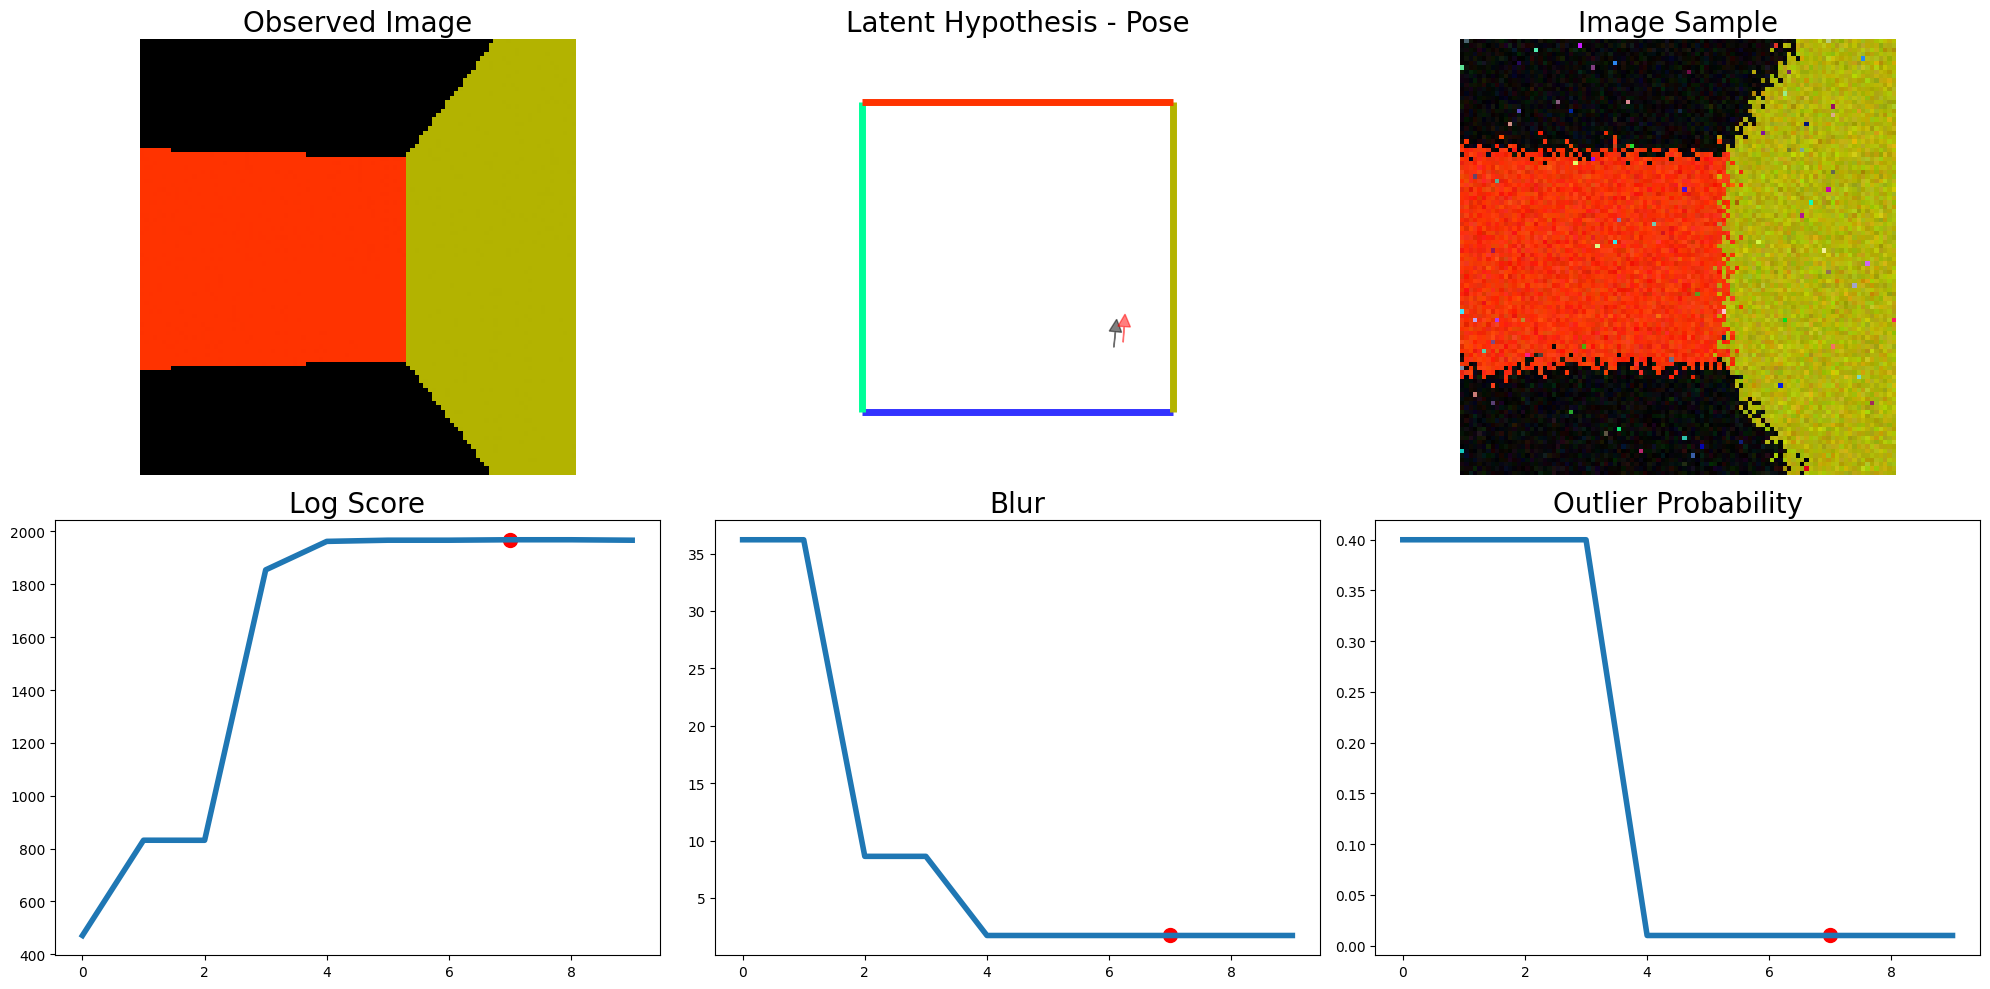

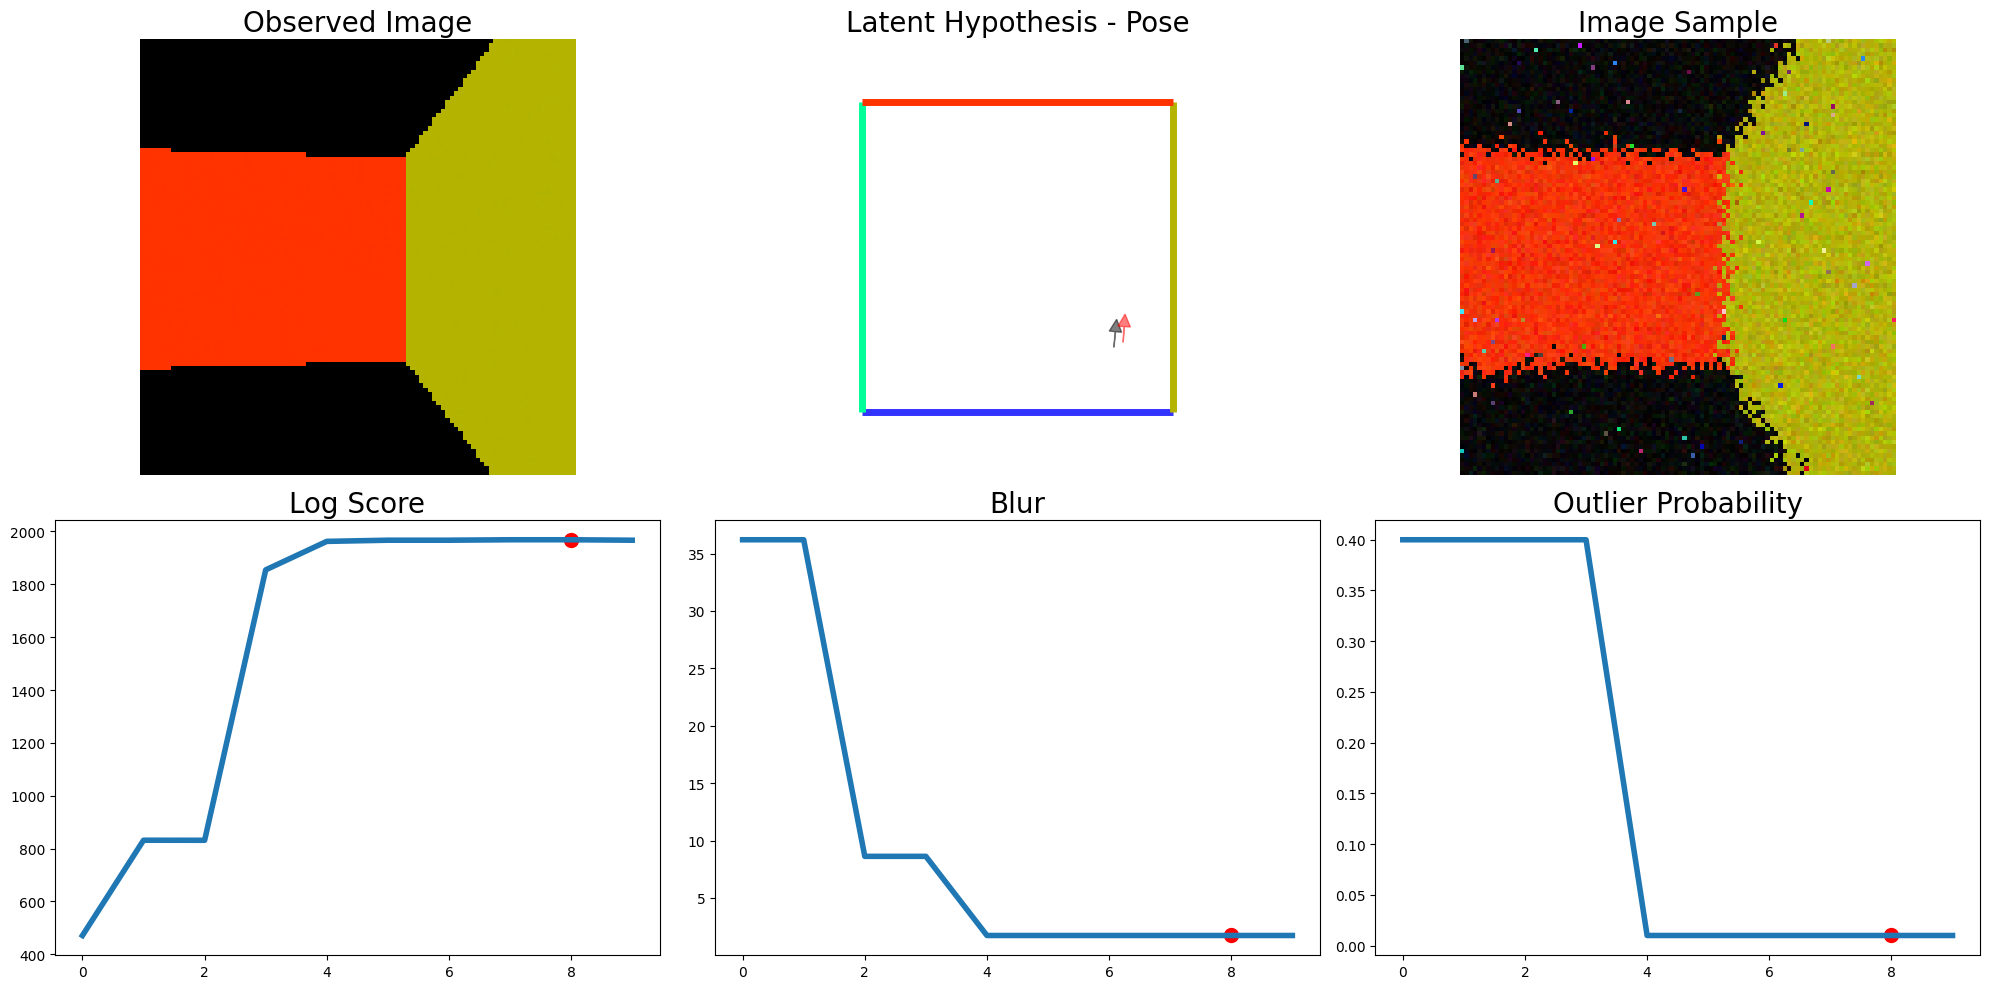

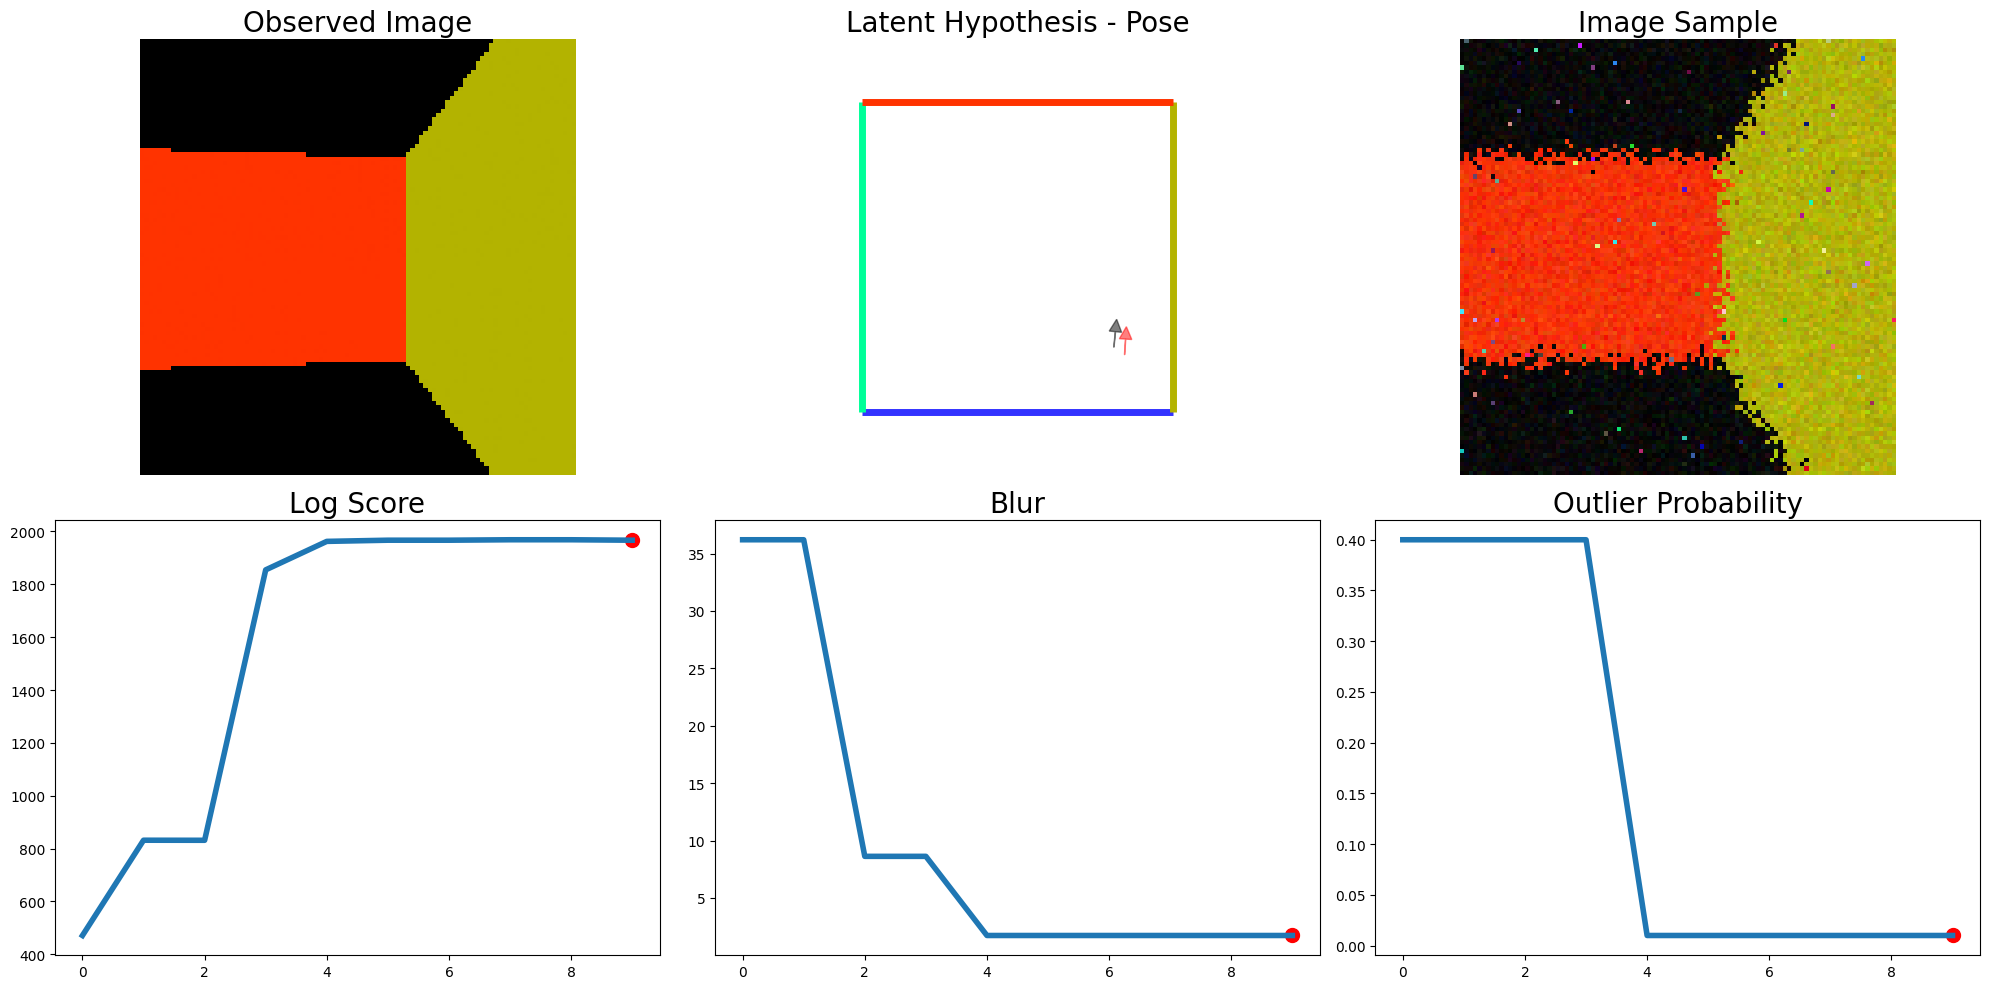

In [184]:
import tempfile
import subprocess

# Generate a random tmp directory name
tmp_dir = tempfile.mkdtemp()
output_filename = "part2.mp4"
fps = 10
# Write files into the tmp directory
for t in range(len(traces)):
    _make_viz(t,os.path.join(tmp_dir, "%07d.png" % t));

subprocess.call(
    [
        "ffmpeg",
        "-hide_banner",
        "-loglevel",
        "error",
        "-y",
        "-r",
        str(fps),
        "-i",
        os.path.join(tmp_dir, "%07d.png"),
        output_filename,
    ]
)


# Part 3: Multi room uncertainty

In [1]:

epsilon = 0.03
num_rooms = 3
line_segments = jnp.concatenate([
    line_segments + jnp.array([(room_w + epsilon) * (i), 0.0, (room_w + epsilon) * (i), 0.0, 0.0, 0.0, 0.0])
    for i in range(num_rooms)
])
world_height = 0.5
world_mesh = Mesh.squeeze_mesh(jax.vmap(line_segment_to_mesh)(line_segments))
world_mesh.rr_visualize("mesh")


NameError: name 'jnp' is not defined

In [ ]:
gt_camera_pose = grid_point_to_pose(jnp.array([1.81, 0.21, 0.1]))
rgbd = renderer.render_rgbd_from_mesh(world_mesh.transform(gt_camera_pose.inv()))

latent_camera_pose = grid_point_to_pose(jnp.array([1.57, 0.21, 0.1]))
choicemap = genjax.ChoiceMap.d(
    {
        "rgbd": rgbd,
        "camera_pose": latent_camera_pose,
        "object_pose_0": Pose.identity(),
        "color_variance_0": 0.2,
        "depth_variance_0": 0.05,
        "outlier_probability_0": 0.01,
        "blur": 100.0,
    }
)

key = jax.random.PRNGKey(0)
trace = importance_jit(
    key,
    choicemap,
    (
        {
            "num_objects": Pytree.const(1),
            "meshes": [world_mesh],
            "likelihood_args": likelikood_args,
        },
    ),
)[0]
viz_trace(trace)

In [ ]:
key = b3d.split_key(key)
addresses= Pytree.const(("color_variance_0","outlier_probability_0","blur"))
sweeps = [color_variance_sweep, outlier_probability_sweep, blur_sweep]
scores = b3d.utils.grid_trace(
    trace,
    addresses,
    sweeps,
)
index = jnp.unravel_index(scores.argmax(), scores.shape)
print(color_variance_sweep[index[0]], outlier_probability_sweep[index[1]], blur_sweep[index[2]])

sampled_indices = jax.vmap(jnp.unravel_index, in_axes=(0, None))(
    jax.random.categorical(key, scores.reshape(-1), shape=(1000,)), scores.shape
)
sampled_parameters = jnp.vstack(
    [sweep[indices] for indices, sweep in zip(sampled_indices, sweeps)]
).T
print(sampled_parameters[:10])
trace = b3d.update_choices(trace, key, addresses, *sampled_parameters[0])
viz_trace(trace)
# viz_trace(importance_jit(
#     key,
#     trace.get_choices().filter( ~S["rgbd"]),
#     trace.get_args(),
# )[0])

In [ ]:
key = b3d.split_key(key)
grid_noise  = (jax.random.uniform(key, base_grid_points.shape) - 0.5) * (high - low) /num
pose_grid = grid_points_to_poses(base_grid_points + grid_noise)
poses = trace.get_choices()["camera_pose"] @ pose_grid

scores = b3d.enumerate_choices_get_scores(
    trace, key,
    Pytree.const(("camera_pose",)), poses,
)


sampled_indices = jax.random.categorical(key, scores , shape=(5000,))

trace = b3d.update_choices(trace, key, address, poses[sampled_indices[0]])
viz_trace(trace)
# viz_trace(importance_jit(
#     key,
#     trace.get_choices().filter( ~S["rgbd"]),
#     trace.get_args(),
# )[0])


In [ ]:
print(trace.get_choices()["blur"])
address = Pytree.const(("camera_pose",))
traces = [trace]



all_poses = []
all_scores = []
key = b3d.split_key(key)
grid_noise  = (jax.random.uniform(key, base_grid_points.shape) - 0.5) * (high - low) /num
pose_grid = grid_points_to_poses(base_grid_points + grid_noise)
poses = trace.get_choices()["camera_pose"] @ pose_grid

scores = b3d.enumerate_choices_get_scores(
    trace, key,
    Pytree.const(("camera_pose",)), poses,
)
all_poses.append(poses)
all_scores.append(scores)

all_poses = Pose.concatenate_poses(all_poses)
all_scores = jnp.concatenate(all_scores)

# subplots 2
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].scatter(
    all_poses.pos[:, 0],
    all_poses.pos[:, 2],
    c=all_scores,
)
new_trace = b3d.update_choices(trace, key, address, sampled_poses[0])
viz_trace(new_trace)

border = 0.2
ax[0].set_xlim(0.0 - border,3.0 + border)
ax[0].set_ylim(0.0 - border,1.0 + border)
ax[0].set_aspect("equal")

sampled_indices = jax.random.categorical(key, all_scores * 0.25 , shape=(5000,))
sampled_indices_unique, counts = jnp.unique(sampled_indices, return_counts=True)
# sampled_poses = all_poses[sampled_indices_unique]
print(counts / counts.sum())
print(all_poses[sampled_indices_unique].pos)
sampled_poses = poses[sampled_indices]
im = ax[1].scatter(
    sampled_poses.pos[:, 0],
    sampled_poses.pos[:, 2],
    # c=counts,
    alpha = 0.005
)
ax[1].set_xlim(0.0 - border,3.0 + border)
ax[1].set_ylim(0.0 - border,1.0 + border)
# fig.colorbar(im, ax=ax[1])
ax[1].set_aspect("equal")
# ax[1].colorbar()

# print(sampled_indices_unique)
# for (t,i) in enumerate(sampled_indices_unique):
#     new_trace = b3d.update_choices(trace, key, Pytree.const(("camera_pose",)), poses[i])
#     print(new_trace.get_choices()["camera_pose"])
#     viz_trace(new_trace,t )

In [ ]:
poses[sampled_indices_unique]

In [ ]:
sampled_indices = jax.random.categorical(key, scores * 0.05 , shape=(5000,))
sampled_poses = poses[sampled_indices]
plt.scatter(
    sampled_poses.pos[:, 0],
    sampled_poses.pos[:, 2],
    c="red",
    alpha = 0.1
)
border = 0.2
plt.xlim(0.0 - border,3.0 + border)
plt.ylim(0.0 - border,1.0 + border)

In [ ]:
key = b3d.split_key(key)
addresses= Pytree.const(("color_variance_0","outlier_probability_0","blur"))
sweeps = [color_variance_sweep, outlier_probability_sweep, blur_sweep]
scores = b3d.utils.grid_trace(
    trace,
    addresses,
    sweeps,
)
index = jnp.unravel_index(scores.argmax(), scores.shape)
print(color_variance_sweep[index[0]], outlier_probability_sweep[index[1]], blur_sweep[index[2]])

sampled_indices = jax.vmap(jnp.unravel_index, in_axes=(0, None))(
    jax.random.categorical(key, scores.reshape(-1), shape=(1000,)), scores.shape
)
sampled_parameters = jnp.vstack(
    [sweep[indices] for indices, sweep in zip(sampled_indices, sweeps)]
).T
print(sampled_parameters[:10])
trace = b3d.update_choices(trace, key, addresses, *sampled_parameters[0])
viz_trace(importance_jit(
    key,
    trace.get_choices().filter( ~S["rgbd"]),
    trace.get_args(),
)[0])

In [ ]:
print(trace.get_choices()["blur"])
key = b3d.split_key(key)
address = Pytree.const(("camera_pose",))
traces = [trace]

grid_noise  = (jax.random.uniform(key, base_grid_points.shape) * ((high - low)/num) - (high - low)/num/2)
pose_grid = grid_points_to_poses(base_grid_points + grid_noise)
poses = trace.get_choices()["camera_pose"] @ pose_grid

scores = b3d.enumerate_choices_get_scores(
    trace, key,
    Pytree.const(("camera_pose",)), poses,
)
sampled_indices = jax.random.categorical(key, scores , shape=(1000,))
sampled_poses = poses[sampled_indices]

plt.scatter(
    sampled_poses.pos[:, 0],
    sampled_poses.pos[:, 2],
)

plt.xlim(0.0,3.0)
plt.ylim(0.0,1.0)

In [ ]:
import jax.random

print(trace.get_choices()["blur"])
key = b3d.split_key(key)
address = Pytree.const(("camera_pose",))
traces = [trace]

grid_noise  = (jax.random.uniform(key, base_grid_points.shape) * ((high - low)/num) - (high - low)/num/2)
pose_grid = grid_points_to_poses(base_grid_points + grid_noise)
poses = trace.get_choices()["camera_pose"] @ pose_grid

for _ in tqdm(range(40)):
    scores = b3d.enumerate_choices_get_scores(
        trace, key,
        Pytree.const(("camera_pose",)), poses,
    )
    sampled_indices = jax.random.categorical(key, scores , shape=(1000,))
    sampled_pose = poses[sampled_indices[0]]
    # sampled_pose = poses[scores.argmax()]
    trace = b3d.update_choices(trace, key, address, sampled_pose)
    traces.append(trace)

poses = Pose.stack_poses([trace.get_choices()["camera_pose"] for trace in traces])

plt.xlim(0.0,3.0)
plt.ylim(0.0,1.0)
viz_trace(trace)

plt.scatter(poses.pos[:, 0], poses.pos[:, 2], alpha=0.5)

In [ ]:
viz_trace(trace)

In [ ]:
key = b3d.split_key(key)
addresses= Pytree.const(("color_variance_0","outlier_probability_0","blur"))
sweeps = [color_variance_sweep, outlier_probability_sweep, blur_sweep]
scores = b3d.utils.grid_trace(
    trace,
    addresses,
    sweeps,
)
index = jnp.unravel_index(scores.argmax(), scores.shape)
print(color_variance_sweep[index[0]], outlier_probability_sweep[index[1]], blur_sweep[index[2]])

sampled_indices = jax.vmap(jnp.unravel_index, in_axes=(0, None))(
    jax.random.categorical(key, scores.reshape(-1), shape=(1000,)), scores.shape
)
sampled_parameters = jnp.vstack(
    [sweep[indices] for indices, sweep in zip(sampled_indices, sweeps)]
).T
print(sampled_parameters[:10])
trace = b3d.update_choices(trace, key, addresses, *sampled_parameters[0])
# plt.plot(color_variance_sweep, scores)

# addresses= Pytree.const(("blur",))
# blur_sweep_dense = jnp.linspace(1.0, 10.0, 200)
# scores = scores = b3d.enumerate_choices_get_scores(
#     trace,
#     key,
#     addresses,
#     blur_sweep_dense,
# )
# plt.plot(blur_sweep_dense, scores)
# print(blur_sweep_dense[scores.argmax()])

In [ ]:
grid_noise  = (jax.random.uniform(key, base_grid_points.shape) * ((high - low)/num) - (high - low)/num/2)
pose_grid = grid_points_to_poses(base_grid_points + grid_noise)
plt.scatter(
    pose_grid.pos[:, 0],
    pose_grid.pos[:, 2],
)

In [ ]:
import jax.random

print(trace.get_choices()["blur"])
key = b3d.split_key(key)
address = Pytree.const(("camera_pose",))
offset_pose = Pose.from_translation(jnp.array([0.01, 0.0, 0.0]))
poses = trace.get_choices()["camera_pose"] @ pose_grid @ offset_pose

scores = scores = b3d.enumerate_choices_get_scores(
    trace,
    key,
    Pytree.const(("camera_pose",)),
    poses,
)

sampled_indices = jax.random.categorical(key, scores , shape=(1000,))

sampled_indices_unique, counts = jnp.unique(sampled_indices, return_counts=True)

sampled_pose = poses[sampled_indices[0]]

print(sampled_indices_unique, counts)

trace = b3d.update_choices(trace, key, address, sampled_pose)

viz_trace(trace)

print(
    poses.pos[sampled_indices, 0][:1], poses.pos[sampled_indices, 2][:1]
)
plt.xlim(0.0,3.0)
plt.ylim(0.0,1.0)
plt.scatter(poses.pos[sampled_indices, 0], poses.pos[sampled_indices, 2], alpha=0.5)

In [ ]:
sortorder = (-scores).argsort()
print(scores[sortorder[:10]])
i = 1
sampled_pose = poses[sortorder[i]]
print(scores[i])
print(sampled_pose)
new_trace = b3d.update_choices(trace, key, address, sampled_pose)
viz_trace(new_trace)

In [ ]:
def log_gaussian_kernel(size: int, sigma: float) -> jnp.ndarray:
    """Creates a 2D Gaussian kernel."""
    ax = jnp.arange(-size // 2 + 1.0, size // 2 + 1.0)
    xx, yy = jnp.meshgrid(ax, ax)
    kernel = -(xx**2 + yy**2) / (2.0 * sigma**2)
    kernel = kernel - jax.nn.logsumexp(kernel)
    return kernel

plt.matshow(jnp.exp(log_gaussian_kernel(31, 10000.0)))
plt.colorbar()

In [ ]:
jnp.exp(log_gaussian_kernel(31, 10000.0))

In [ ]:
a = scores.sort()
print(a[-2:])
b3d.normalize_log_scores(a[-2:])

In [ ]:
sampled_indices = jax.random.categorical(key, scores * 0.2, shape=(1000,))

sampled_indices_unique, counts = jnp.unique(sampled_indices, return_counts=True)
sampled_pose = poses[sampled_indices[0]]
print(sampled_indices_unique, counts)
sampled_trace = b3d.update_choices(trace, key, address, sampled_pose)
viz_trace(sampled_trace)

plt.scatter(grid[sampled_indices, 0], grid[sampled_indices, 2], alpha=0.5)

In [ ]:
blur_sweep

In [ ]:
observed_camera_pose = Pose.from_translation(jnp.array([0.81, 0.0, 0.21]))
latent_camera_pose = Pose.from_translation(jnp.array([0.83, 0.0, 0.21]))
observed_rgb = renderer.render_rgbd_from_mesh(
    world_mesh.transform(observed_camera_pose.inv())
)[..., :3]
latent_rgb = renderer.render_rgbd_from_mesh(
    world_mesh.transform(latent_camera_pose.inv())
)[..., :3]

b3d.rr_log_rgb("image", observed_rgb)
b3d.rr_log_rgb("image/latent", latent_rgb)

scores = likelihood_vmap_blur(observed_rgb, latent_rgb, {"blur": blur_sweep})
print(scores)
# b3d.rr_log_depth("b", likelihood_per_pixel(observed_rgb, latent_rgb, 0.01))
# b3d.rr_log_depth("b/higher_noise", likelihood_per_pixel(observed_rgb, latent_rgb, 10.0))
# # b3d.rr_log_depth("b/diff", likelihood_per_pixel(observed_rgb, latent_rgb, 0.01) - likelihood_per_pixel(observed_rgb, latent_rgb, 1.0))

# blur_sweep = jnp.linspace(0.01, 10.5, 100)
# scores = likelihood_vmap_blur(observed_rgb, latent_rgb, blur_sweep)
# print(blur_sweep[scores.argmax()])
# plt.plot(blur_sweep, scores)

In [ ]:
latent_rgb_padded = jnp.pad(
    latent_rgb,
    (
        (filter_size, filter_size),
        (filter_size, filter_size),
        (0, 0),
    ),
    mode="edge",
)
jj, ii = jnp.meshgrid(
    jnp.arange(observed_rgb.shape[1]), jnp.arange(observed_rgb.shape[0])
)
indices = jnp.stack([ii, jj], axis=-1)
ij = jnp.array([54, 65])


latent_rgb_padded_window = jax.lax.dynamic_slice(
    latent_rgb_padded,
    (ij[0], ij[1], 0),
    (2 * filter_size + 1, 2 * filter_size + 1, 3),
)
scores_inlier = genjax.truncated_normal.logpdf(
    observed_rgb[ij[0], ij[1], :], latent_rgb_padded_window, 0.03, 0.0, 1.0
).sum(-1)
plt.imshow(latent_rgb_padded_window)
plt.matshow(scores_inlier)
plt.colorbar()

blur = 0.01
log_kernel = gaussian_kernel(2 * filter_size + 1, blur)
averaged_prob = jax.nn.logsumexp(jax.nn.logsumexp(scores_inlier + log_kernel))
averaged_prob = jax.nn.logsumexp(jax.nn.logsumexp(scores_inlier + log_kernel))
print(averaged_prob)

In [ ]:
plt.matshow(log_kernel)
plt.colorbar()

In [ ]:
print(
    genjax.truncated_normal.logpdf(
        jnp.array([1.0, 1.0, 0.0]), jnp.array([0.0, 0.0, 1.0]), 0.03, 0.0, 1.0
    ).sum(-1)
)

log_kernel = gaussian_kernel(2 * filter_size + 1, blur)
plt.matshow(log_kernel)

In [ ]:
b3d.rr_log_depth("b", likelihood_per_pixel(observed_rgb, latent_rgb, 0.01))
b3d.rr_log_depth("b/higher_noise", likelihood_per_pixel(observed_rgb, latent_rgb, 10.0))
# b3d.rr_log_depth("b/diff", likelihood_per_pixel(observed_rgb, latent_rgb, 0.01) - likelihood_per_pixel(observed_rgb, latent_rgb, 1.0))

In [ ]:
blur = 10.0
kernel = log_gaussian_kernel(2 * filter_size + 1, blur)
print(kernel.sum())
plt.matshow(jnp.exp(kernel))
plt.colorbar()
print(jnp.exp(kernel).sum())

In [ ]:
lower_bound = jnp.array([0.0, 0.0, 0.0, 0.0])
upper_bound = jnp.array([1.0, 1.0, 1.0, 3.0])
convert_rgbd_to_color_space = lambda x: x
convert_color_space_to_rgbd = lambda x: x


# convert_rgbd_to_color_space = lambda x: b3d.colors.rgbd_to_labd(x)
# convert_color_space_to_rgbd = lambda x: b3d.colors.labd_to_rgbd(x)
def intermediate_likelihood_func(observed_rgbd, latent_rgbd, likelihood_args):
    k = likelihood_args["k"].const
    fx = likelihood_args["fx"]
    fy = likelihood_args["fy"]

    outlier_probability_0 = likelihood_args[f"outlier_probability_0"]
    # lightness_variance_0 = likelihood_args[f"lightness_variance_0"]
    color_variance_0 = likelihood_args[f"color_variance_0"]
    # depth_variance_0 = likelihood_args[f"depth_variance_0"]

    inlier_variances_0 = jnp.array(
        [color_variance_0, color_variance_0, color_variance_0, color_variance_0]
    )
    outlier_variances = jnp.array([1000000.0, 1000000.0, 1000000.0, 1000000.0])

    image_height, image_width = observed_rgbd.shape[:2]

    blur = likelihood_args["blur"]
    observed_color_space_d = apply_gaussian_blur_rgbd(
        observed_rgbd[..., :3], blur, kernel_size
    )
    latent_color_space_d = apply_gaussian_blur_rgbd(observed_rgb, blur, kernel_size)

    scores_inlier = genjax.truncated_normal.logpdf(
        observed_color_space_d, latent_color_space_d, color_variance_0, 0.0, 1.0
    ) + jnp.log(1.0 - outlier_probability_0)
    scores_outlier = genjax.truncated_normal.logpdf(
        observed_color_space_d, 0.5, 0.1, 0.0, 1.0
    ) + jnp.log(outlier_probability_0)
    print(scores_inlier.shape)
    print(scores_outlier.shape)

    return {
        "score": pixelwise_score.sum(),
        "observed_color_space_d": observed_color_space_d,
        "latent_color_space_d": latent_color_space_d,
        "pixelwise_score": pixelwise_score,
    }

    # subset_observed = observed_color_space_d
    # subset_observed_rescaled = (subset_observed - lower_bound) / (
    #     upper_bound - lower_bound
    # )
    # rendered_values_rescaled = (latent_color_space_d - lower_bound) / (
    #     upper_bound - lower_bound
    # )

    # scores_inlier = jax.vmap(
    #     genjax.truncated_normal.logpdf, in_axes=(0, 0, None, None, None)
    # )(subset_observed_rescaled, rendered_values_rescaled, inlier_variances_0, 0.0, 1.0)
    # scores_outlier = jax.vmap(
    #     genjax.truncated_normal.logpdf, in_axes=(0, None, None, None, None)
    # )(subset_observed_rescaled, 0.5, outlier_variances, 0.0, 1.0)

    # scores_inlier_merged = scores_inlier[..., :3].sum(-1) + jnp.log(
    #     1.0 - outlier_probability_0
    # )
    # scores_outlier_merged = scores_outlier[..., :3].sum(-1) + jnp.log(
    #     outlier_probability_0
    # )

    # pixelwise_score = jnp.logaddexp(scores_inlier_merged, scores_outlier_merged)
    # pixelwise_score_full = jnp.zeros((image_height, image_width))
    # pixelwise_score_full = pixelwise_score

    return {
        "score": pixelwise_score_full.sum(),
        # "score": (
        #     jax.nn.logsumexp(pixelwise_score_full) - jnp.log(pixelwise_score_full.size)
        # )
        # * k,
        "observed_color_space_d": observed_color_space_d,
        "latent_color_space_d": latent_color_space_d,
        "pixelwise_score": pixelwise_score_full,
    }


import b3d.chisight.dense.dense_model

b3d.reload(b3d.chisight.dense.dense_model)
model, viz_trace, info_from_trace = (
    b3d.chisight.dense.dense_model.make_dense_multiobject_model(
        renderer, intermediate_likelihood_func
    )
)
importance_jit = jax.jit(model.importance)


grid1 = b3d.multivmap(b3d.update_choices_get_score, (False, False, False, True))
grid2 = b3d.multivmap(b3d.update_choices_get_score, (False, False, False, True, True))
grid3 = b3d.multivmap(
    b3d.update_choices_get_score, (False, False, False, True, True, True)
)
grid4 = b3d.multivmap(
    b3d.update_choices_get_score, (False, False, False, True, True, True, True)
)

In [ ]:
IDX = 4
key = jax.random.PRNGKey(0)
likelikood_args = {
    "fx": renderer.fx,
    "fy": renderer.fy,
    "cx": renderer.cx,
    "cy": renderer.cy,
    "k": Pytree.const(50),
}

T = 22
choicemap = genjax.ChoiceMap.d(
    {
        "rgbd": rgbd,
        "object_pose_0": Pose.identity(),
        "camera_pose": Pose.from_translation(
            gt_camera_pose.pos + jnp.array([0.1, 0.0, -0.01])
        ),
        # "outlier_probability_0": 0.1,
        # "color_variance_0": 0.2,
    }
)

trace = importance_jit(
    key,
    choicemap,
    (
        {
            "num_objects": Pytree.const(1),
            "meshes": [world_mesh],
            "likelihood_args": likelikood_args,
        },
    ),
)[0]
print(trace.get_score())
viz_trace(trace)

In [ ]:
import jax.random

key = b3d.split_key(key)

gt_translation = trace.get_choices()["camera_pose"].pos
w = 3.1
wz = 1.0
grid = b3d.utils.make_grid_points(
    jnp.array([gt_translation[0] - w, gt_translation[1], gt_translation[2] - wz]),
    jnp.array([gt_translation[0] + w, gt_translation[1], gt_translation[2] + wz]),
    jnp.array([41, 1, 31]),
)
poses = Pose.from_translation(grid)
address = Pytree.const(("camera_pose",))
scores = grid1(trace, key, Pytree.const(("camera_pose",)), poses)
sampled_indices = jax.random.categorical(key, scores, shape=(1000,))

# print(sampled_indices)
sampled_indices_unique, counts = jnp.unique(sampled_indices, return_counts=True)
sampled_pose = poses[sampled_indices[0]]
print(sampled_indices_unique, counts)
sampled_trace = b3d.update_choices(trace, key, address, sampled_pose)
viz_trace(sampled_trace)

plt.scatter(grid[sampled_indices, 0], grid[sampled_indices, 2], alpha=0.5)

In [ ]:
plt.scatter(poses.pos[:, 0], poses.pos[:, 2], c=scores)
plt.colorbar()

In [ ]:
scores = b3d.enumerate_choices_get_scores(
    trace,
    key,
    Pytree.const(("blur",)),
    blur_sweep,
)
plt.plot(blur_sweep, scores)

In [ ]:
outlier_probability_sweep = jnp.linspace(0.001, 0.2, 30)
color_variance_sweep = jnp.linspace(0.1, 0.3, 15)
blur_sweep = jnp.linspace(0.01, 1.0, 15)

for arguments in [
    Pytree.const(
        (
            "outlier_probability_background",
            "color_variance_background",
        )
    ),
]:
    key = jax.random.split(key, 2)[-1]

    # arguments = Pytree.const(("outlier_probability_background", "lightness_variance_background", "color_variance_background", "depth_variance_background",))
    sweeps = [
        outlier_probability_sweep,
        color_variance_sweep,
        # blur_sweep,
    ]

    scores = grid2(trace, key, arguments, *sweeps)
    sampled_indices = jax.vmap(jnp.unravel_index, in_axes=(0, None))(
        jax.random.categorical(key, scores.reshape(-1), shape=(1000,)), scores.shape
    )
    sampled_parameters = jnp.vstack(
        [sweep[indices] for indices, sweep in zip(sampled_indices, sweeps)]
    ).T

    print(sampled_parameters[0])
    trace = b3d.update_choices(
        trace,
        key,
        arguments,
        # 0.05, 1.0, 0.02, 0.01
        *sampled_parameters[0],
    )
    print(trace.get_score())
    viz_trace(trace)
    info_from_trace(trace)["score"]

In [ ]:
scores = b3d.enumerate_choices_get_scores(
    trace,
    key,
    Pytree.const(("blur",)),
    blur_sweep,
)
plt.plot(blur_sweep, scores)

In [ ]:
import jax.random

key = b3d.split_key(key)

gt_translation = trace.get_choices()["camera_pose"].pos
w = 3.1
wz = 1.0
grid = b3d.utils.make_grid_points(
    jnp.array([gt_translation[0] - w, gt_translation[1], gt_translation[2] - wz]),
    jnp.array([gt_translation[0] + w, gt_translation[1], gt_translation[2] + wz]),
    jnp.array([41, 1, 31]),
)
poses = Pose.from_translation(grid)
address = Pytree.const(("camera_pose",))
scores = grid1(trace, key, Pytree.const(("camera_pose",)), poses)
sampled_indices = jax.random.categorical(key, scores, shape=(1000,))

# print(sampled_indices)
sampled_indices_unique, counts = jnp.unique(sampled_indices, return_counts=True)
sampled_pose = poses[sampled_indices[0]]
print(sampled_indices_unique, counts)
sampled_trace = b3d.update_choices(trace, key, address, sampled_pose)
viz_trace(sampled_trace)

plt.scatter(grid[sampled_indices, 0], grid[sampled_indices, 2], alpha=0.5)

In [ ]:
plt.scatter(poses.pos[:, 0], poses.pos[:, 2], c=scores)
plt.colorbar()

In [ ]:
import trimesh

mesh = trimesh.load("identical_rooms_single_mesh.obj")
# mesh = Mesh.from_obj("identical_rooms_single_mesh.obj")
mesh.vertices

In [ ]:
b3d.rr_init("slam")

In [ ]:
obj = Mesh.from_obj("identical_rooms_single_mesh.obj")
obj.rr_visualize("mesh")